<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### Rigid Transformations in Lower Dimensional Space for Subsurface Uncertainty Quantification and Interpretation


#### Midé Mabadeje$^{1}$ (PhD Candidate) & Michael Pyrcz$^{1,2}$ (Professor), University of Texas at Austin

 1. Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

 2. Department of Geological Sciences, Jackson School of Geosciences


## Introduction

Here is an example of the workflow as applied on South Kaybob field from the Duvernay formation.

## Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/).
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal.
3. In the terminal type: pip install geostatspy.
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality.

### Import Libraries

In [1]:
import numpy as np                        # ndarray for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import seaborn as sns                     # for matrix scatter plots
import matplotlib.pyplot as plt
import RigidTransformation_UQI_OOSP as RT      # imports script consisting of functions to run workflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
get_ipython()

### Set the working directory

I always like to do this so, I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).

In [3]:
%pwd # grab current working directory

'/Users/ademidemabadeje/Documents/UT/Research/PyCharm/LD_Stabilization/Fall 2022/Notebooks/Current'

In [4]:
os.chdir('/Users/ademidemabadeje/Documents/UT/Research/PyCharm/LD_Stabilization/Realization results OOSP/Duvernay')    # set the working directory to results directory

#### Data

Load comma delimited data file into a Pandas' DataFrame object.

In [5]:
df = pd.read_csv('South Kaybob.csv')
df.head()

API           X            Y  Pore Pressure  Thickness  \
0  100052806018W500  256.818665  6072.238414      15.595800  36.322800   
1  100013105918W500  262.522883  6063.768151      16.414499  28.556400   
2  100153605920W500  273.711783  6063.267474      17.809000  32.216599   
3  100012106321W500  283.769714  6105.233958      17.500999  31.287800   
4  100010106320W500  267.388443  6097.573707      17.108200  33.366402   

   Porosity  Oil Saturation  Cum. Gas  
0  0.067142        0.067404  0.520823  
1  0.072521        0.076301  1.450993  
2  0.072394        0.088561  1.721126  
3  0.076772        0.201194  1.337968  
4  0.066267        0.121996  0.693374

This dataset has features from 55 unconventional wells including:

0. A unique well identifier
1. East (Km) Location coordinate
2. North (Km) Location coordinate
3. Pore Pressure (MPa)
4. Reservoir thickness at given X,Y coordinates
5. Average well porosity (fraction)
6. Oil saturation (fraction)
7. Cumulative oil production (MMCFPD).


<br>

#### Summary Statistics

Let's check the summary statistics of our data.

In [6]:
df.describe().transpose()

count         mean        std          min          25%  \
X                55.0   272.476529   9.722572   246.835352   267.460701   
Y                55.0  6080.589300  12.566253  6056.076555  6070.329451   
Pore Pressure    55.0    17.384204   0.950216    14.195200    17.318450   
Thickness        55.0    34.990467   2.332798    28.556400    33.478100   
Porosity         55.0     0.069952   0.003741     0.061360     0.067826   
Oil Saturation   55.0     0.082908   0.027783     0.040814     0.066293   
Cum. Gas         55.0     1.095829   0.644421     0.008319     0.538646   

                        50%          75%          max  
X                272.664300   280.047185   291.004193  
Y               6080.037566  6090.342374  6105.233958  
Pore Pressure     17.739099    17.984900    18.308399  
Thickness         34.850899    36.591200    40.230701  
Porosity           0.069551     0.071566     0.081356  
Oil Saturation     0.075171     0.091317     0.201194  
Cum. Gas           1.062077     1.510583     2.833428

Summary statistics are a critical first step in data checking. 

* this includes the number of valid (non-null) values for each feature (count removes all np.NaN from the totals for each variable).

* we can see the general behaviours such as central tendency, mean, and dispersion, variance.

* we can identify issue with negative values, extreme values, and values that are outside the range of plausible values for each property. 

* We can also establish the feature ranges for plotting.  We could calculate the feature range directly from the data with code like this:

```p
Pormin = np.min(df['Porosity'].values)          # extract ndarray of data table column
Pormax = np.max(df['Porosity'].values)          # and calculate min and max
```

but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting. 

In [7]:
# user specified min and max values, and labels for plotting
pormin = 0.06; pormax = 0.082; porname = 'PHI (fraction)'; portitle = 'Porosity'
presmin = 14.15; presmax = 18.31; presname = 'Pore Pressure (Mpa)'; prestitle = 'Pore Pressure'
thickmin = 28.50; thickmax = 40.25; thickname = 'H (Km)'; thicktitle = 'Thickness'
somin = 0.04; somax = 0.21; soname = 'So (fraction)'; sotitle = 'Oil Saturation'
prodmin = 0.008; prodmax = 2.85; prodname = 'Np (MMCFPD)'; prodtitle = 'Cumulative Production'

In [8]:
# Rename features as needed
df = df.copy(deep=True)
df.rename(columns={'Porosity': porname, 'Pore Pressure': presname, 'Thickness': thickname, 'Oil Saturation': soname, 'Cum. Gas': prodname}, inplace=True)

Summary statistics show data is good as-is. Next, visualize data distributions with a martix scatter plot.

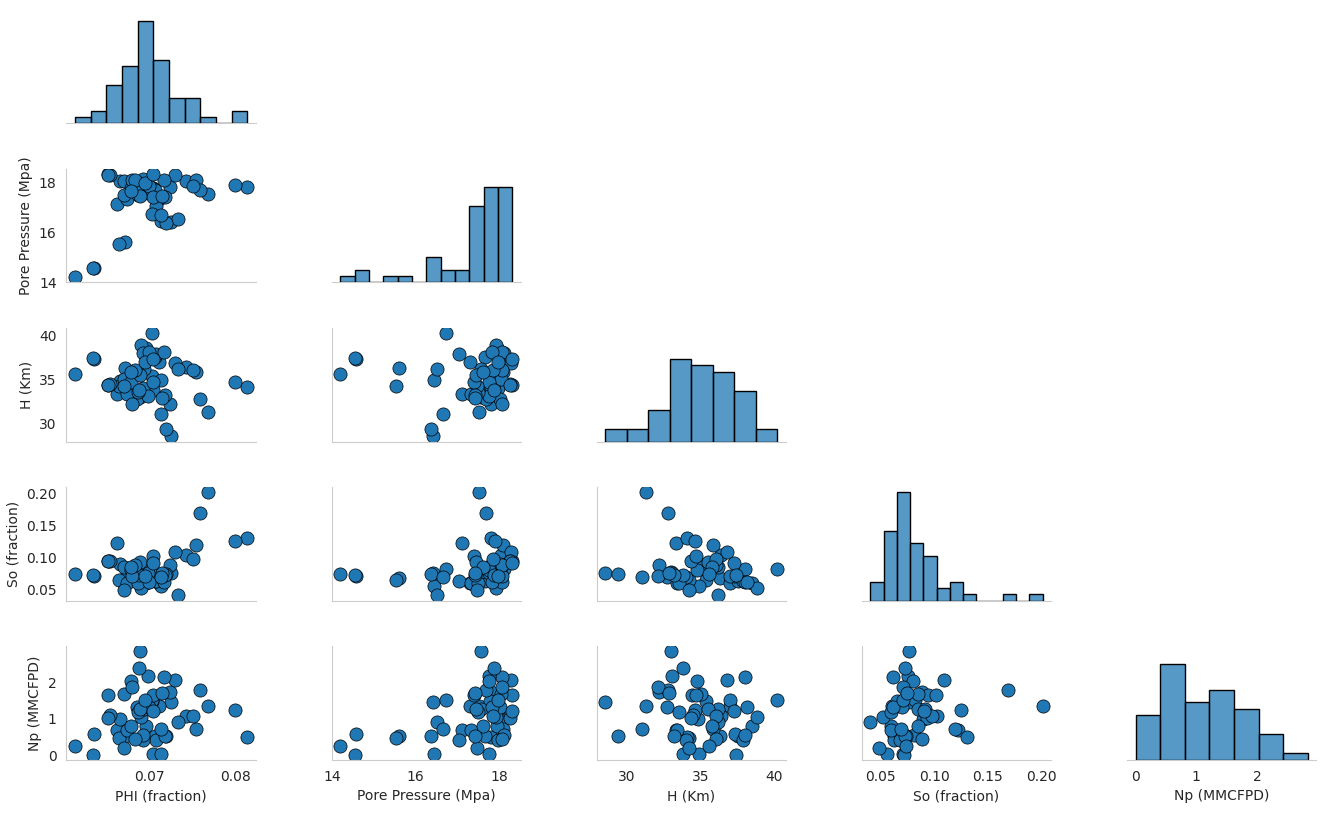

In [9]:
RT.matrix_scatter(df, [porname, presname, thickname, soname, prodname], 0., 0., 1., 0.6, 0.4, 0.4, 'Scatterplot of all features for entire data', 1, hue_=None, num_OOSP=None, n_case=True, save=True)

Visualize the distributions colored by varying levels of production as a categorical variable.

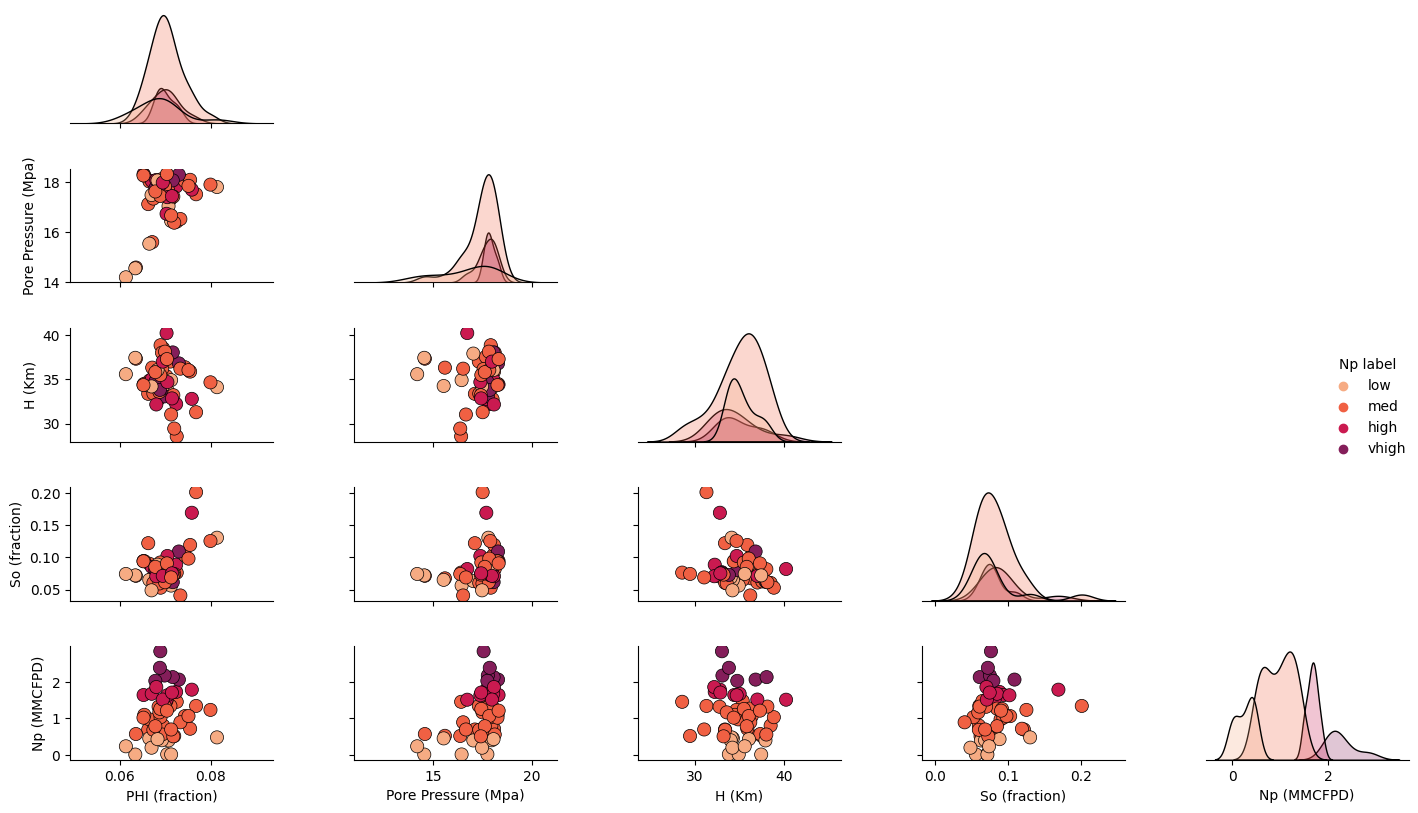

In [10]:
response = 'Np label'
num_response = 'Np (MMCFPD)'
custom_bins = [0, 0.5, 1.5, 2.0, 2.9]

# Add category for response variable i.e., production levels for complete dataset
df = RT.make_levels(data=df, cat_response=response, num_response=num_response, custom_bins=custom_bins)
RT.matrix_scatter(df, [porname, presname, thickname, soname, prodname], 0., 0., 1., 0.6, 0.4, 0.4, 'Scatterplot of all features coded by production levels for entire dataset', 1, hue_='Np label', num_OOSP=None, n_case=True, save=True)

Prepare dataset and curate parameters/variables needed for N case and N+1 (OOSP) cases such that the OOSP's added are within 95% CI.

In [11]:
# N case
N = len(df)
num_OOSP = 1
df_subset = df.iloc[:N,1:-1]

# N+1 i.e., OOSP case.
df_subset2, random_seeds_used = RT.make_sample_within_ci(df_subset.copy(), num_OOSP=num_OOSP)

# save random seed used for OOSP generation
np.save('Random seed array for OOSP.npy', random_seeds_used)

# Insert well column index back into data frame for N+1 case
df_subset2.insert(0, 'Well', np.arange(1, len(df_subset2)+1))

# Insert well column index back into data frame for N case
df_subset.insert(0, 'Well', np.arange(1, len(df_subset)+1))

# Select predictor features of interest for proposed workflow
features = [porname, presname, thickname, soname]

#### Data Preparation

Make an ordinal feature from the continuous production:

1. low
2. medium
3. high
4. very high

production rates.  This will help visualize the results as we proceed, we can look at wells with different levels of production projected into a variety of lower dimensional spaces (LDS) with multidimensional scaling.

<br>

Let's start with the N-samples case

In [12]:
# Dataset for use in N case inclusive of category for response variable i.e., production levels
df_subset = RT.make_levels(data=df_subset, cat_response=response, num_response=num_response, custom_bins=custom_bins)
df_subset.head()

Well           X            Y  Pore Pressure (Mpa)     H (Km)  \
0     1  256.818665  6072.238414            15.595800  36.322800   
1     2  262.522883  6063.768151            16.414499  28.556400   
2     3  273.711783  6063.267474            17.809000  32.216599   
3     4  283.769714  6105.233958            17.500999  31.287800   
4     5  267.388443  6097.573707            17.108200  33.366402   

   PHI (fraction)  So (fraction)  Np (MMCFPD) Np label  
0        0.067142       0.067404     0.520823      med  
1        0.072521       0.076301     1.450993      med  
2        0.072394       0.088561     1.721126     high  
3        0.076772       0.201194     1.337968      med  
4        0.066267       0.121996     0.693374      med

Take a look at the matrix scatter plot of our 4 predictor features and the production levels for N case samples

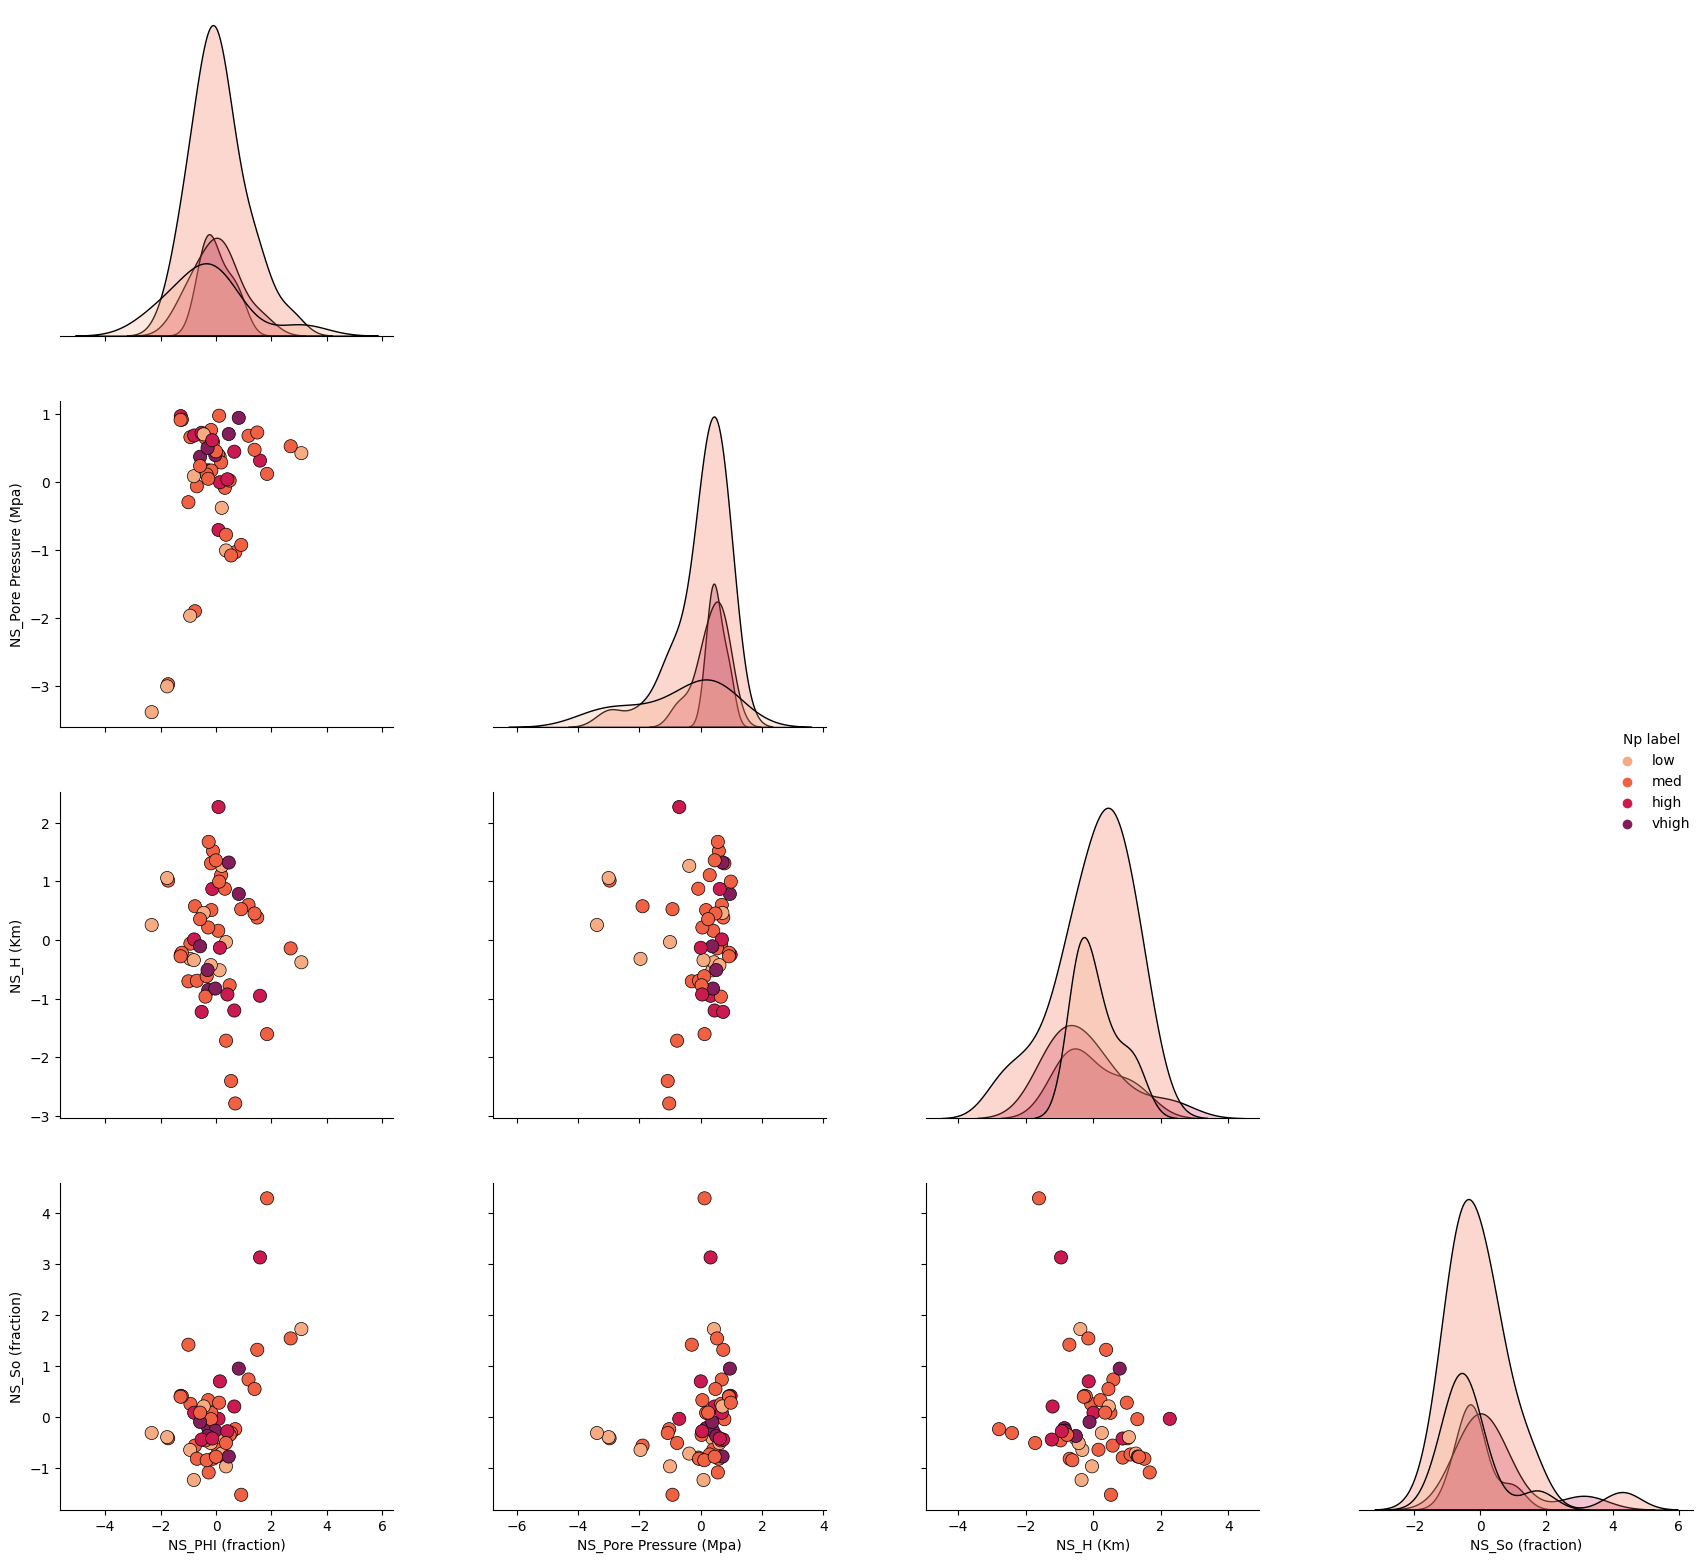

In [13]:
# Visualize the N-case dataset standardized

other_df = RT.standardizer(df_subset, features, keep_only_std_features=False)

# Visualize the matrix scatter plot of the 3 standardized features and the response i.e., production levels.
RT.matrix_scatter(other_df, ['NS_' + porname, 'NS_' + presname, 'NS_' + thickname, 'NS_' + soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2, 'Scatterplot of standardized features colored by production levels for N case samples', 1, hue_=response, num_OOSP=None, n_case=True)

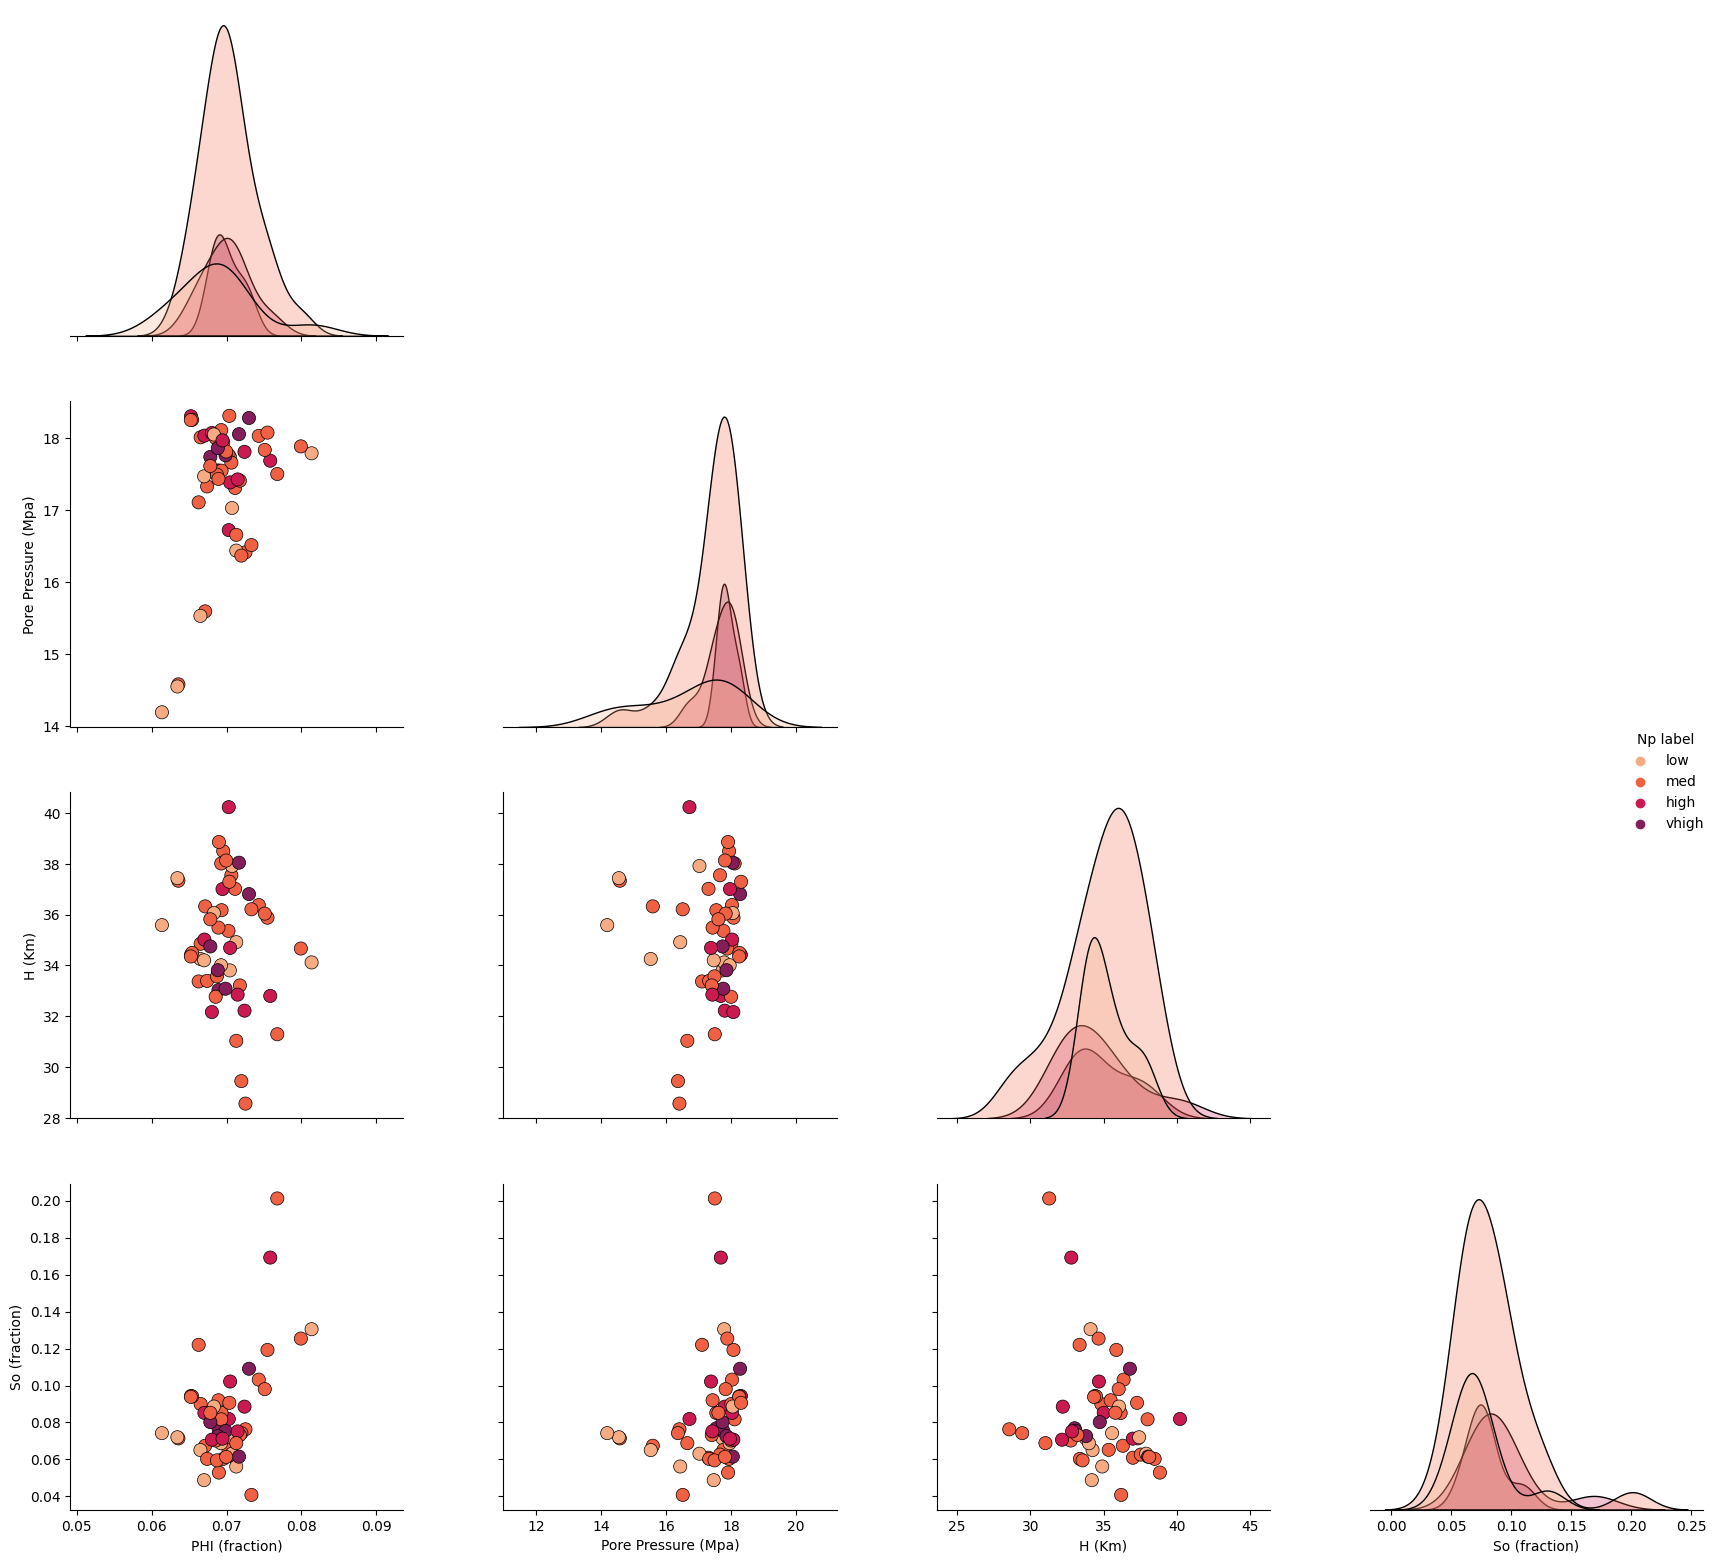

In [14]:
# Visualize the N-case dataset in original feature space

# Visualize the matrix scatter plot of the 4 features chosen and the response i.e., production levels in the original space.
RT.matrix_scatter(other_df, [porname, presname, thickname, soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2,
                  'Scatterplot of features colored by production levels for N case samples', 1, hue_=response, num_OOSP=None, n_case=True)

Similarly, let's visualize the N+1 samples case with OOSP's.

In [15]:
# Dataset for use in N+1 case inclusive of category for response variable i.e., production levels
df_subset2 = RT.make_levels(data=df_subset2, cat_response=response, num_response=num_response, custom_bins=custom_bins)
df_subset2.tail()

Well           X            Y  Pore Pressure (Mpa)     H (Km)  \
51    52  269.164582  6066.192067            17.426201  32.848202   
52    53  264.530629  6064.212989            16.656700  31.028900   
53    54  253.003356  6074.277992            14.553200  37.434601   
54    55  246.835352  6069.342789            14.195200  35.585300   
55    56  270.564213  6079.050203            17.473910  34.677084   

    PHI (fraction)  So (fraction)  Np (MMCFPD) Np label  
51        0.071474       0.075171     1.703615     high  
52        0.071294       0.068825     0.694409      med  
53        0.063429       0.072001     0.008319      low  
54        0.061360       0.074235     0.234323      low  
55        0.069961       0.089930     1.072183      med

Look at the matrix scatter plot of our 4 features and the production levels for N+1 case samples with OOSP.

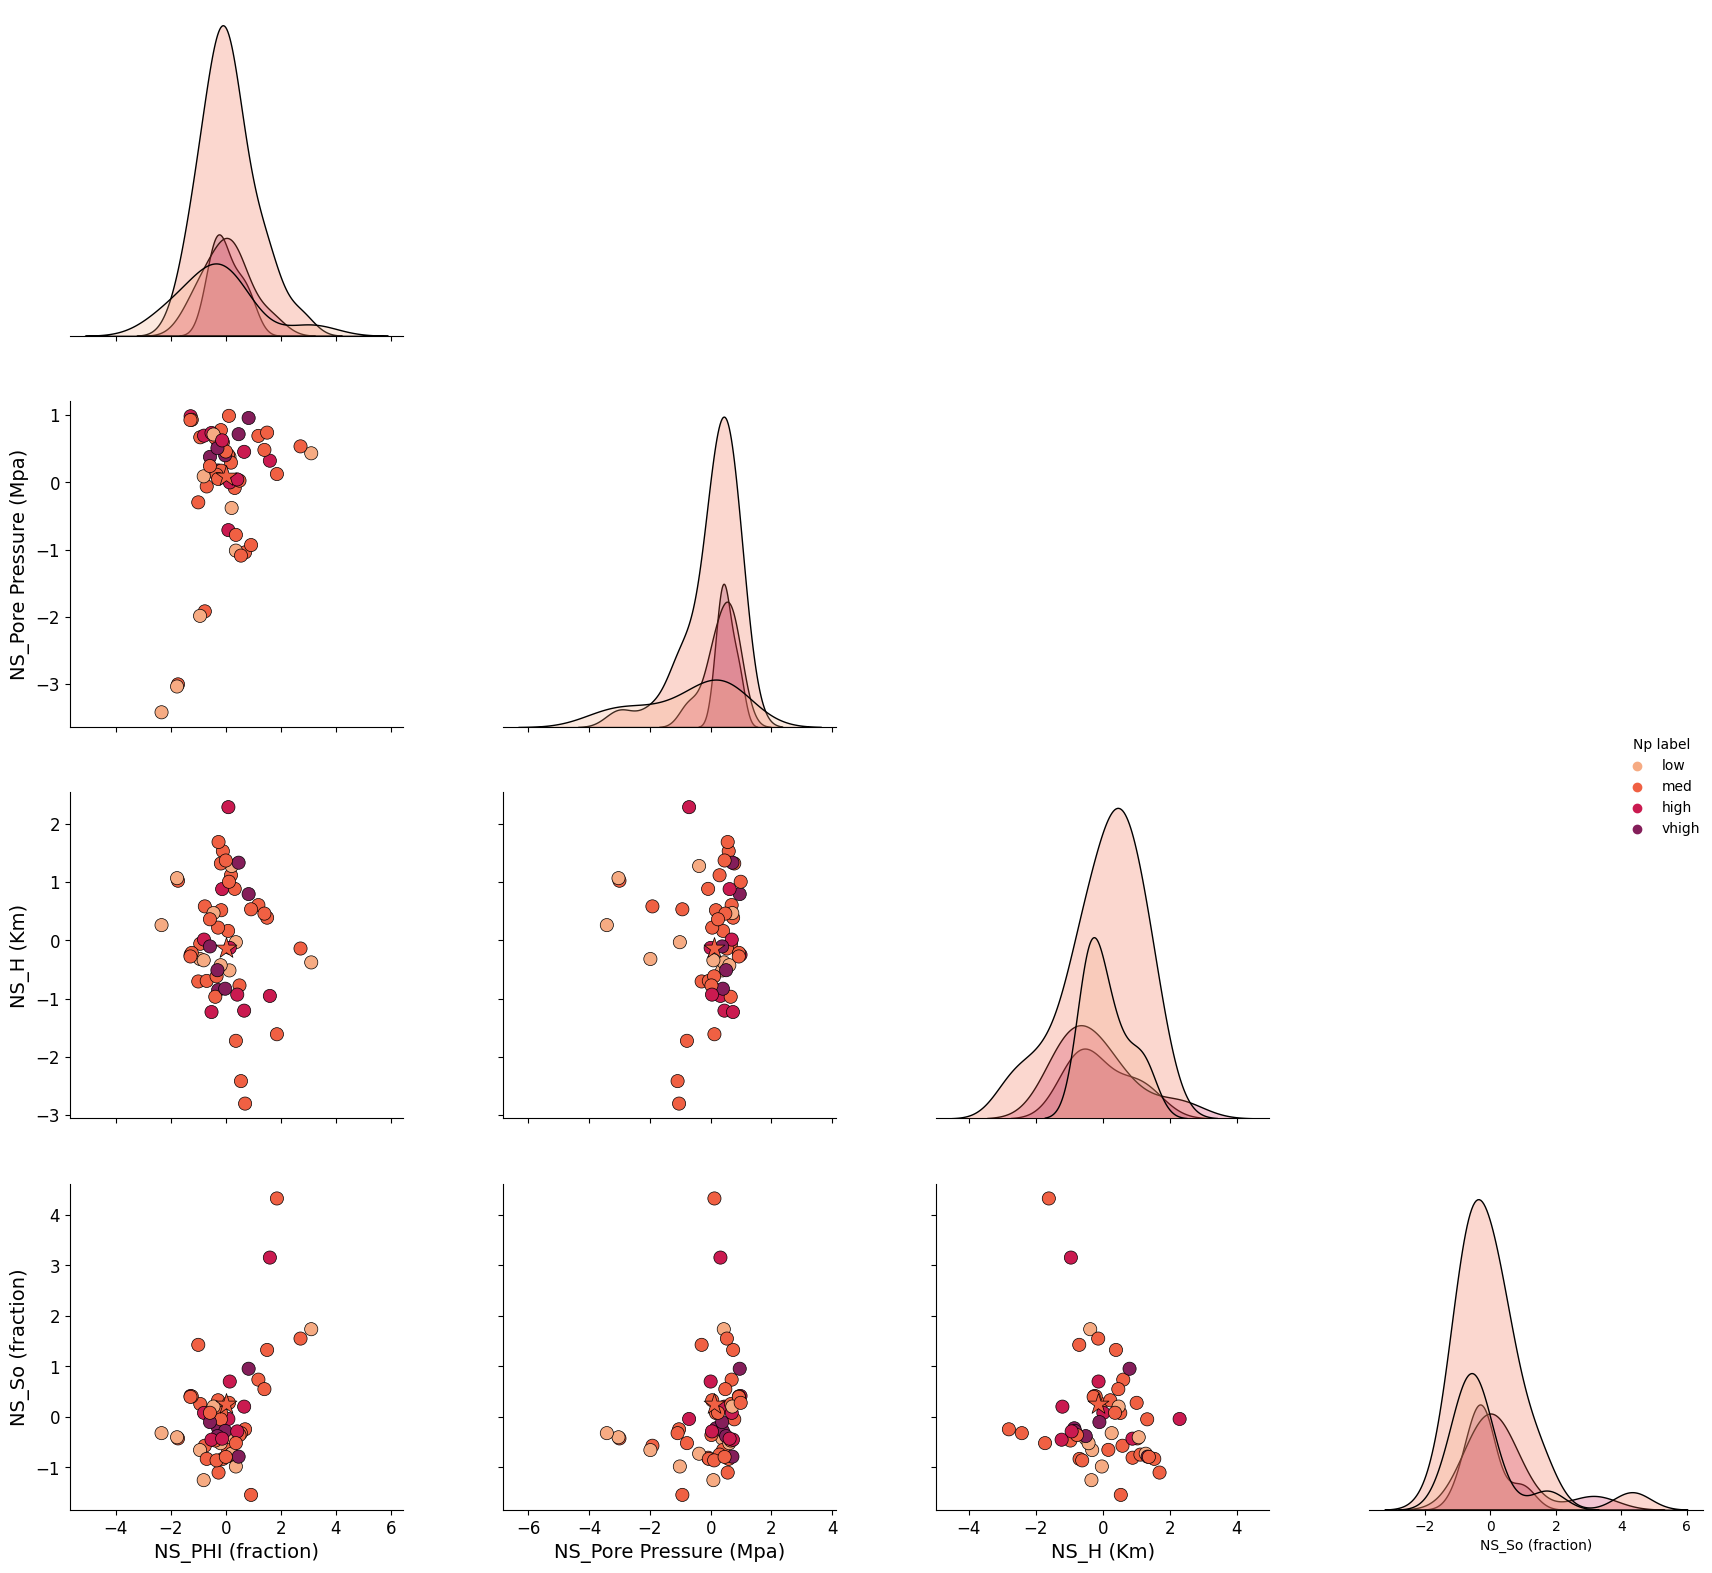

In [16]:
# Visualize the N+1 case dataset standardized

other_df = RT.standardizer(df_subset2, features, keep_only_std_features=False)

# Visualize the matrix scatter plot of the 3 standardized features and the response i.e., production levels.

RT.matrix_scatter(other_df, ['NS_' + porname, 'NS_' + presname, 'NS_' + thickname, 'NS_' + soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2, 'Scatterplot of standardized features colored by production levels for N+1 case samples', 1, hue_=response, num_OOSP=num_OOSP, n_case=False, save=True)

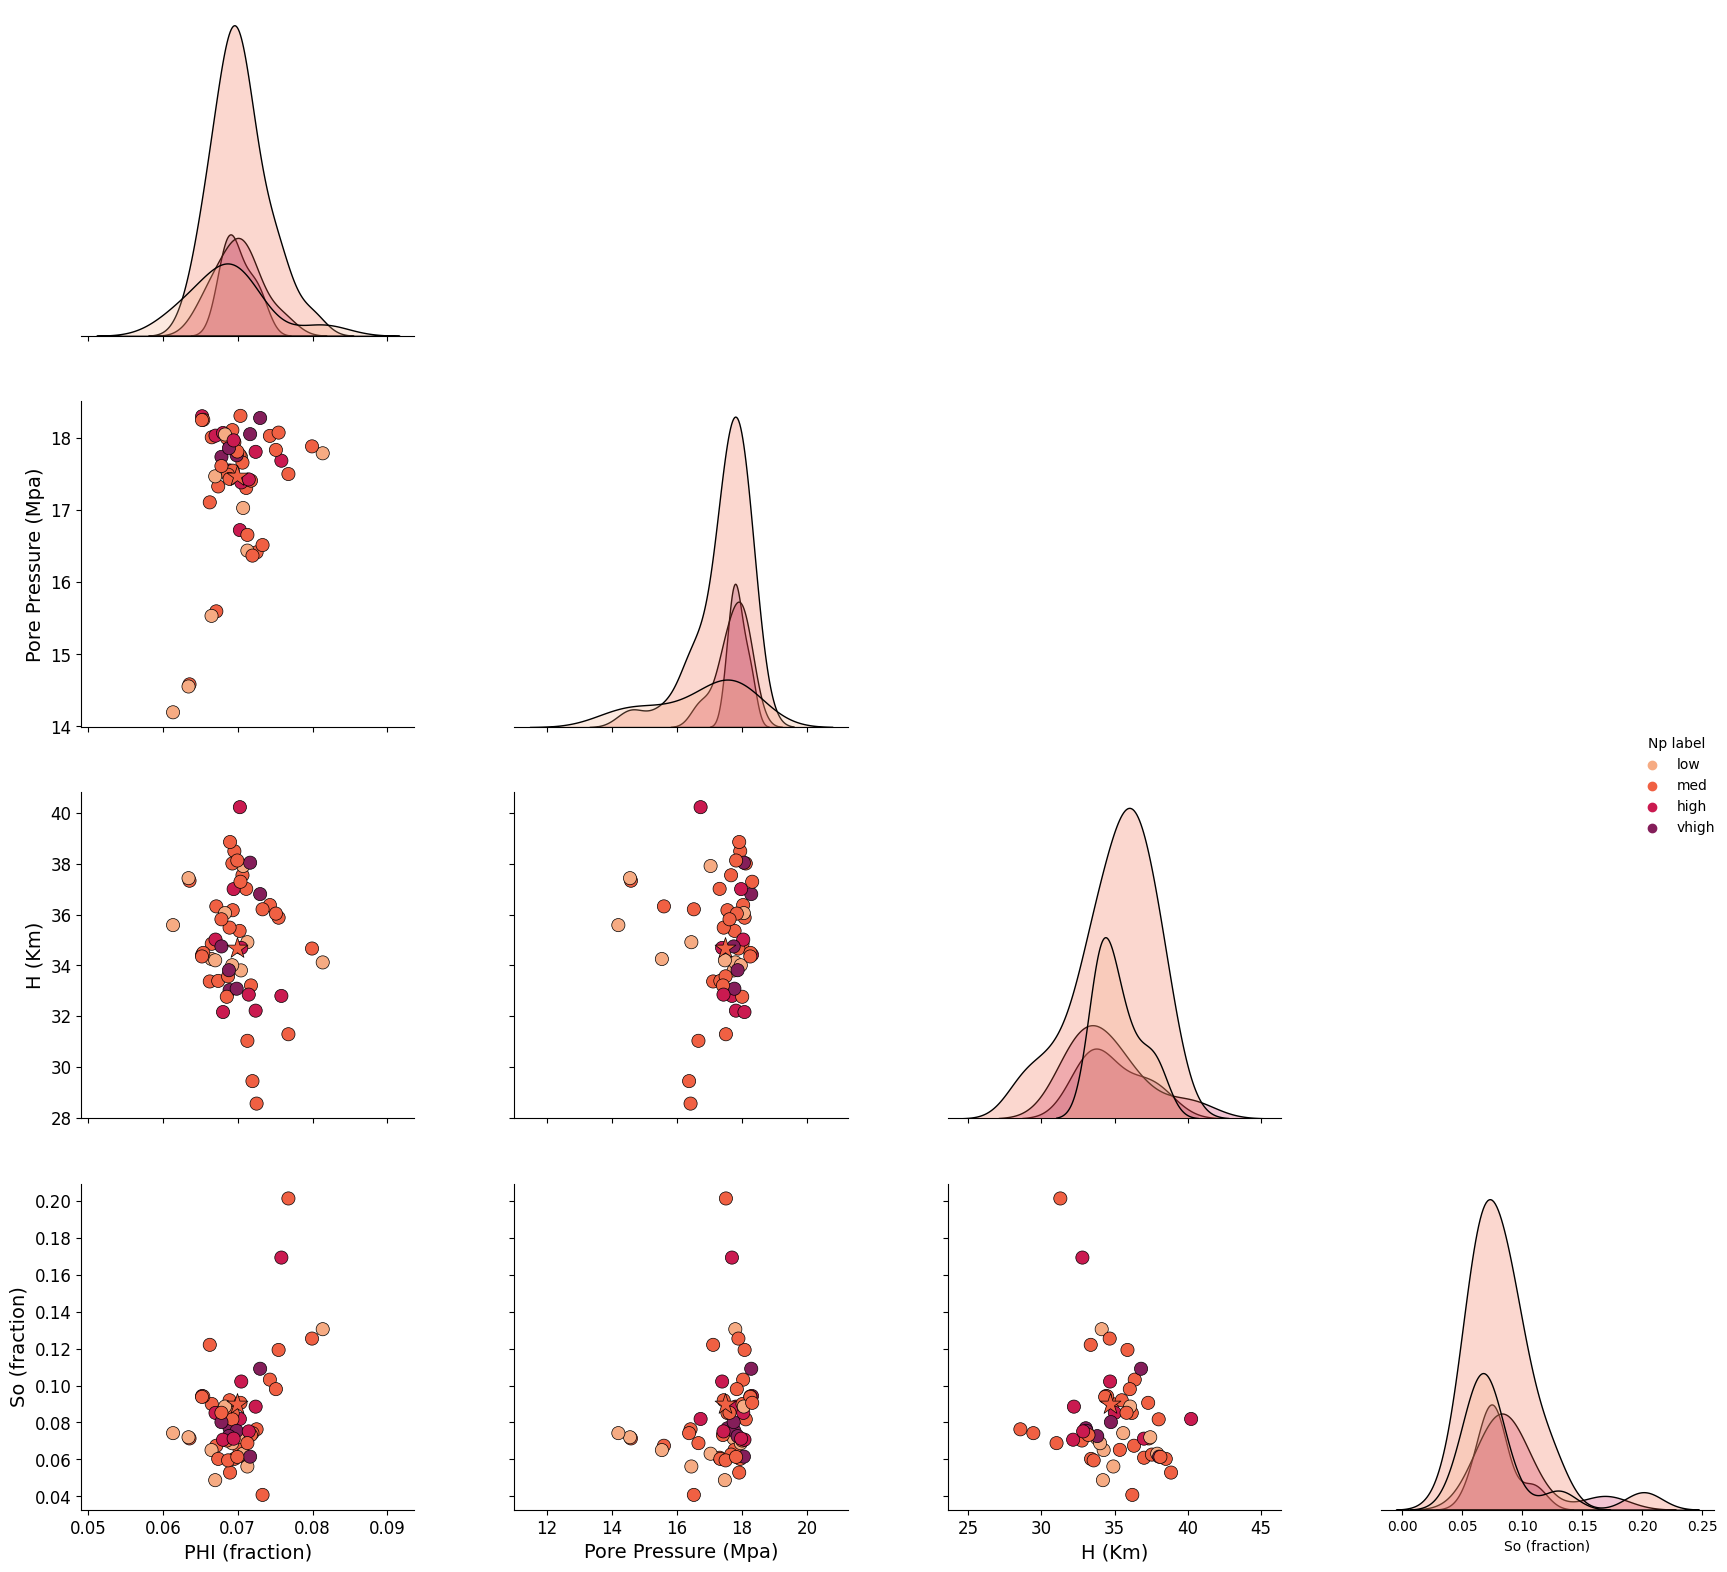

In [17]:
# Visualize the N+1 case dataset in original feature space

# Visualize the matrix scatter plot of the 3 standardized features and the response i.e., production levels.

RT.matrix_scatter(other_df, [porname, presname, thickname, soname], 0.0, 0.0, 1.5, 1.5, 0.3, 0.2,
                  'Scatterplot of features colored by production levels for N+1 case samples', 1, hue_=response, num_OOSP=num_OOSP, n_case=False, save=True)

# r'NS_AI  ($\mathrm{kg \, m^2/s}$)' for label in latex

# Workflow Application

## Section 1: N-case samples

Take the entire dataset, then instantiate the class. Do note that standardization and tabular outlier detection is performed on the features under the hood, this is imperative as our model works with dissimilarity-based distance metric.

In [18]:
# Curate parameters and variables
num_realizations = 100
base_seed = 42
start_seed = 1
stop_seed = 10000
idx = 'Well'
dissimilarity_metric="mahalanobis"
make_figure = True
dim_projection = '2d' # since the projection (p), is to 2 features. Use '3d' if the projection is to 3 features
normalize_projections = False

# Instantiate the class
obj = RT.RigidTransformation(df=df_subset, features=features, num_OOSP=num_OOSP, idx=idx, num_realizations=num_realizations, base_seed=base_seed, start_seed=start_seed, stop_seed=stop_seed, dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection, custom_dij=None)

# Run rigid MDS
random_seeds, all_real, calc_real, all_rmse, norm_stress = obj.run_rigid_MDS(normalize_projections=normalize_projections)

Visualize the base case and three example realizations to highlight difference in LDS obtained

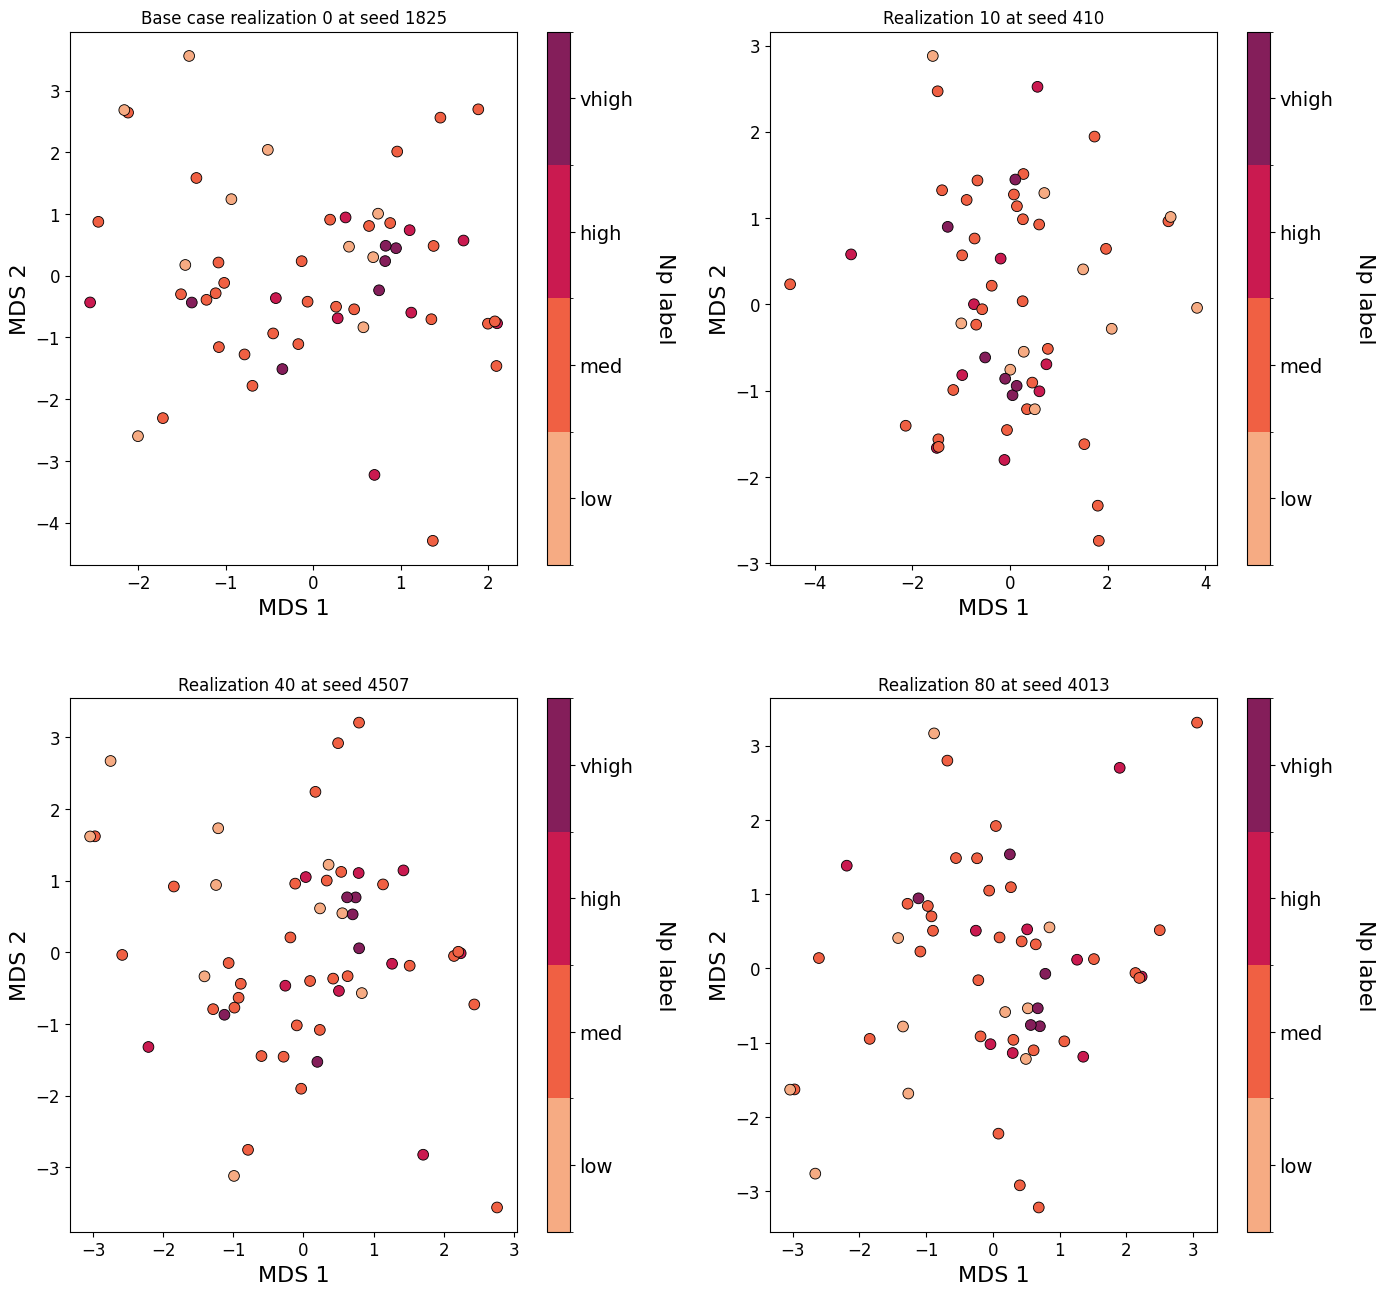

In [19]:
response='Np label'
r_list=[0, 10, 40, 80]
Ax='MDS 1'
Ay='MDS 2'
title=['Base case realization ', 'Realization ', 'Realization ', 'Realization ']
x_off=0.02
y_off=0.07

#Set color map criteria
dpalette = sns.color_palette("rocket_r",n_colors = len(df_subset[response].unique()) + 1)
cmap=dpalette

obj.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off,cmap=dpalette, annotate=False, n_case=True, array2=None, save=True)

Prior to stabilization of data points, visualize all realizations on the same plot to show MDS is not rotation invariant.

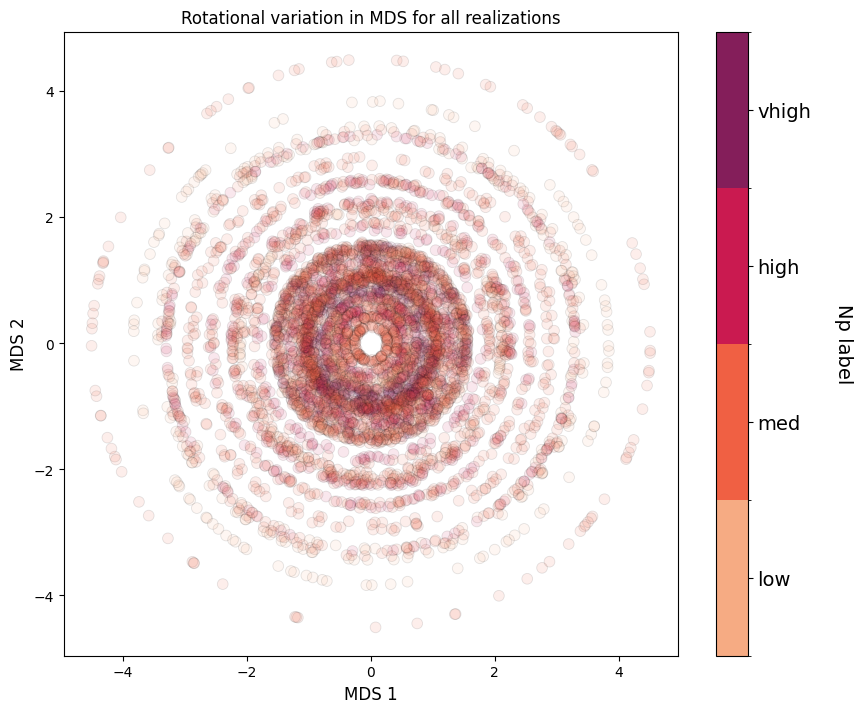

In [20]:
obj.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='Rotational variation in MDS for all realizations',
                     plot_type='variation', Ax=Ax, Ay=Ay, annotate=False, save=True)

Visualize the base case, previously chosen realizations and respective stabilized solutions.

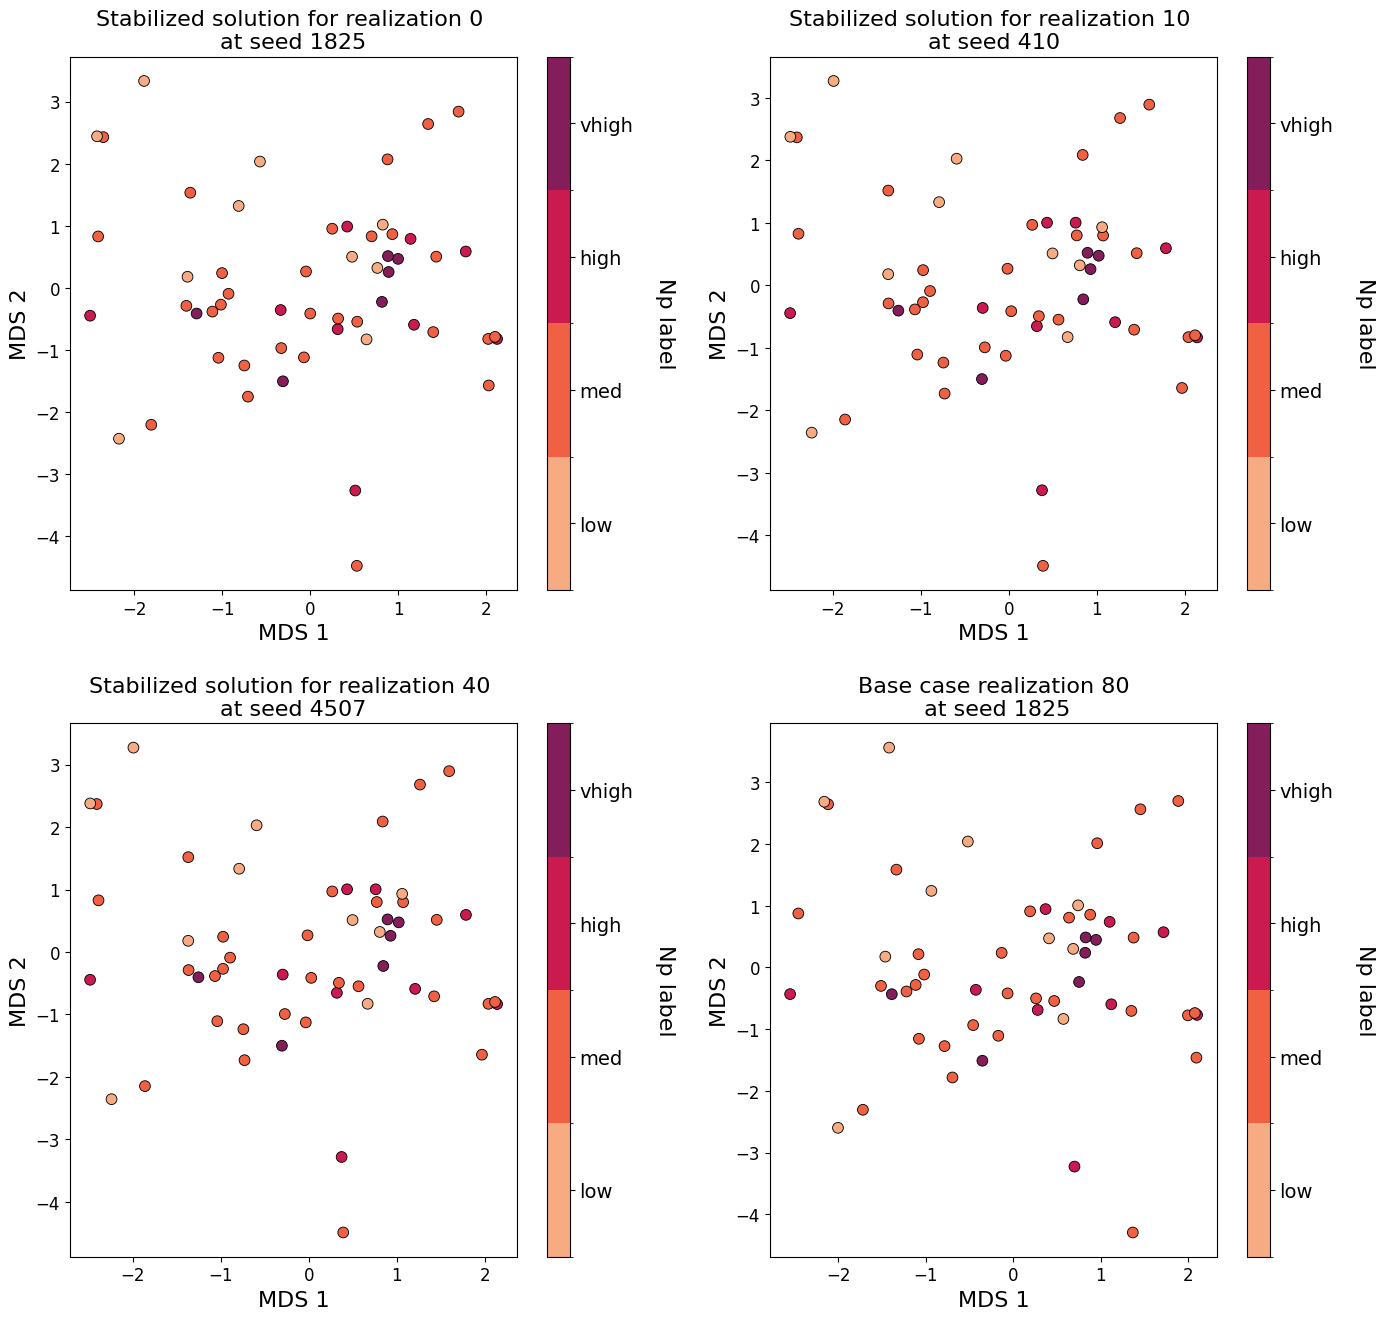

In [21]:
obj.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off, annotate=False, cmap=dpalette, array2=calc_real, n_case=True, save=True)

The realization examples are perfectly transformed to match the base case although slight distortion is seen in the base case even though all sample points are registered correctly.


Next, visualize the 2D registration jitters in the newly found stabilized solutions.

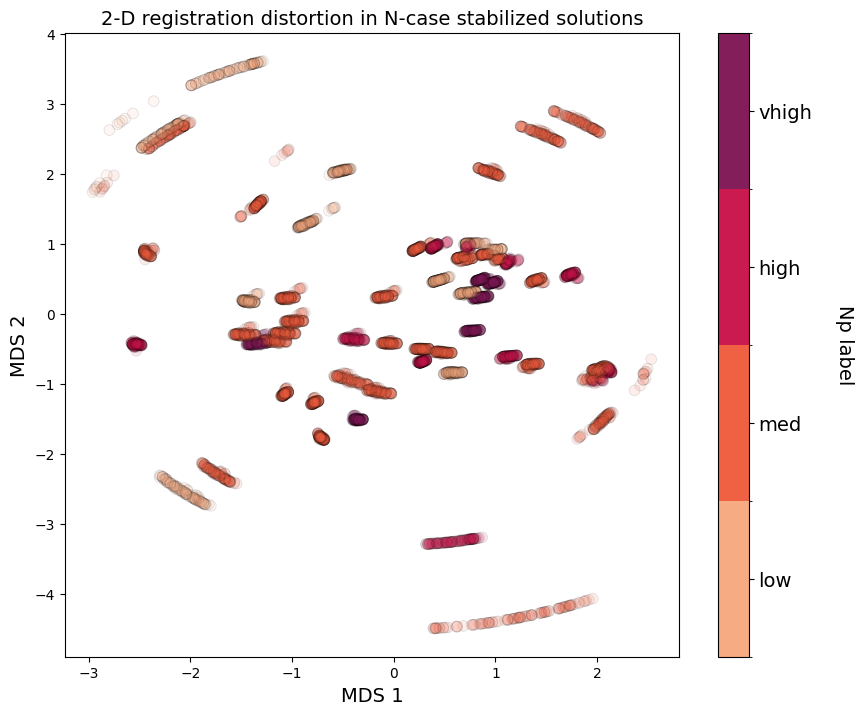

In [22]:
obj.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='2-D registration distortion in N-case stabilized solutions',
                         plot_type='jitters', Ax=Ax, Ay=Ay, annotate=False, save=True)

We see the distortions albeit not yet quantified for each sample in the dataset in the above figure, so we visualize the expectation of these stabilized solutions.

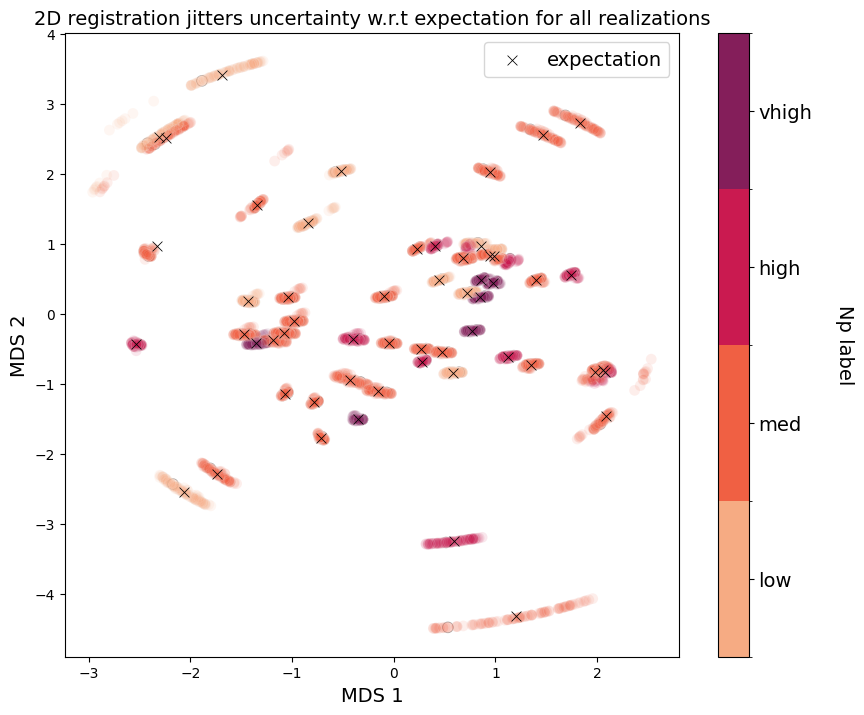

In [23]:
obj.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='2D registration jitters uncertainty w.r.t expectation for all realizations',
                         plot_type='uncertainty', Ax=Ax, Ay=Ay, annotate=False, save=True)

Based on the scenarios above, we see that regardless of the seed or random state used when computing the MDS projections, similar stabilized solutions are obtained with distortions/jitters. Next, we average out the stabilized solutions obtained to get a more accurate location for the projections in the MDS space by obtaining the expectation of the ith sample over enough realizations as the ground truth projection coordinates.


Note that using the ensemble expectation of the stabilized solution helps removed effects from slight random offsets, perturbations, or distortions if any within the n-sample demonstration.

In [24]:
# Set base case index of choice
bc_idx =0


E = obj.expectation(r_idx=bc_idx, Ax=Ax, Ay=Ay, verbose=True)

The effective variance of the base case is 3.7793 with a MDS 1 variance of 1.6177 and MDS 2 variance of 2.1616
The effective variance of the expected stabilized solution is 3.7567 with a MDS 1 variance of 1.6268 and MDS 2 variance of 2.1299


Visualize the ensemble expectation of the stabilized MDS projections over multiple realizations compared to the base case.

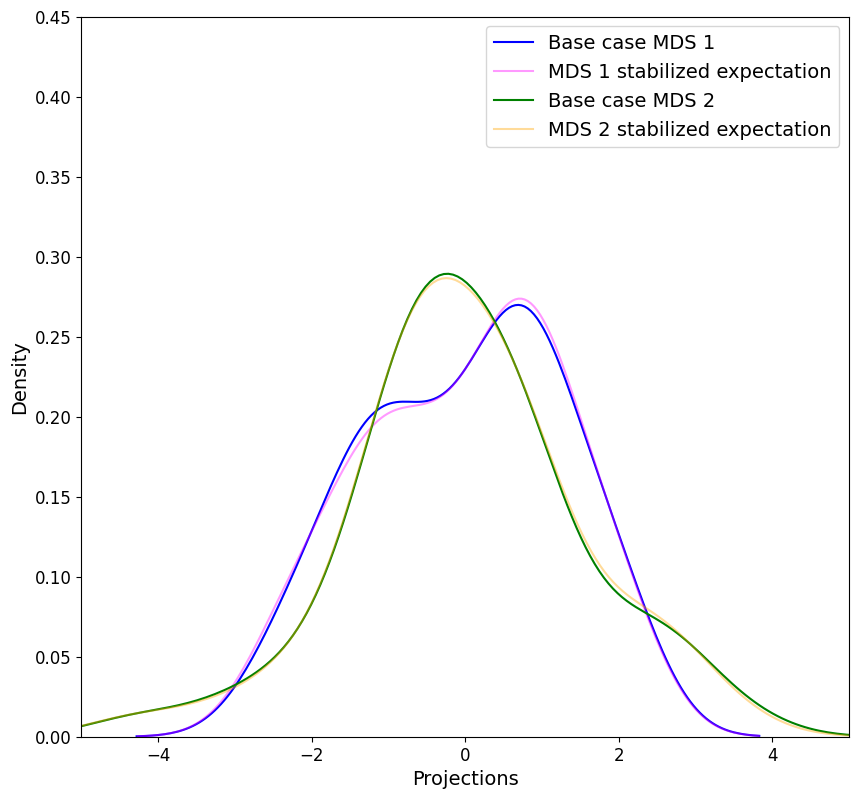

In [25]:
xmin = -5
xmax = 5
ymin = 0.0
ymax = 0.45

obj.expect_plotter(r_idx=bc_idx, Lx=Ax, Ly=Ay, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, save=True)

Visualize base case with ensemble expectation of the stabilized solution over all realizations for comparison for the N sample case.

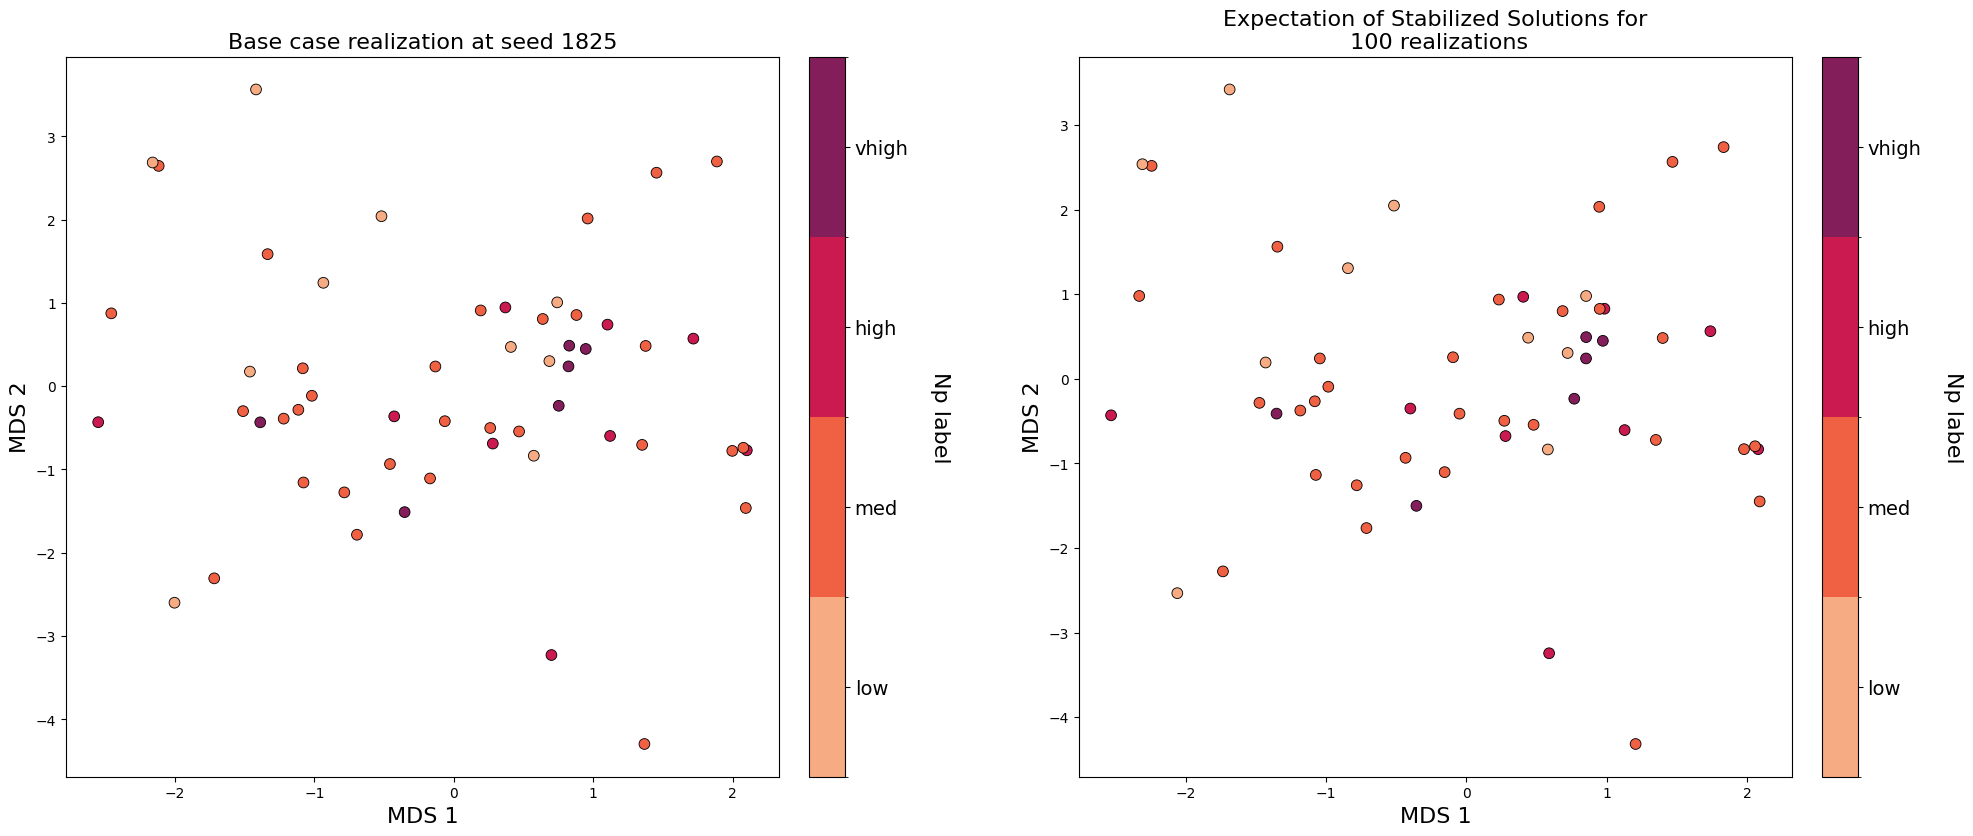

In [26]:
obj.compare_plot(response=response, r_idx=bc_idx, Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off, n_case=True, annotate=False, cmap=dpalette, save=True)

Let's check our model:

* we will calculate the original and projected pairwise distances between all the samples

* we will cross plot the original vs the projects pairwise distances

* we will plot the distribution of the ratio between projects / original pariwise distances

Now, let's calculate the distortion between original and projected pairwise distances between all samples.

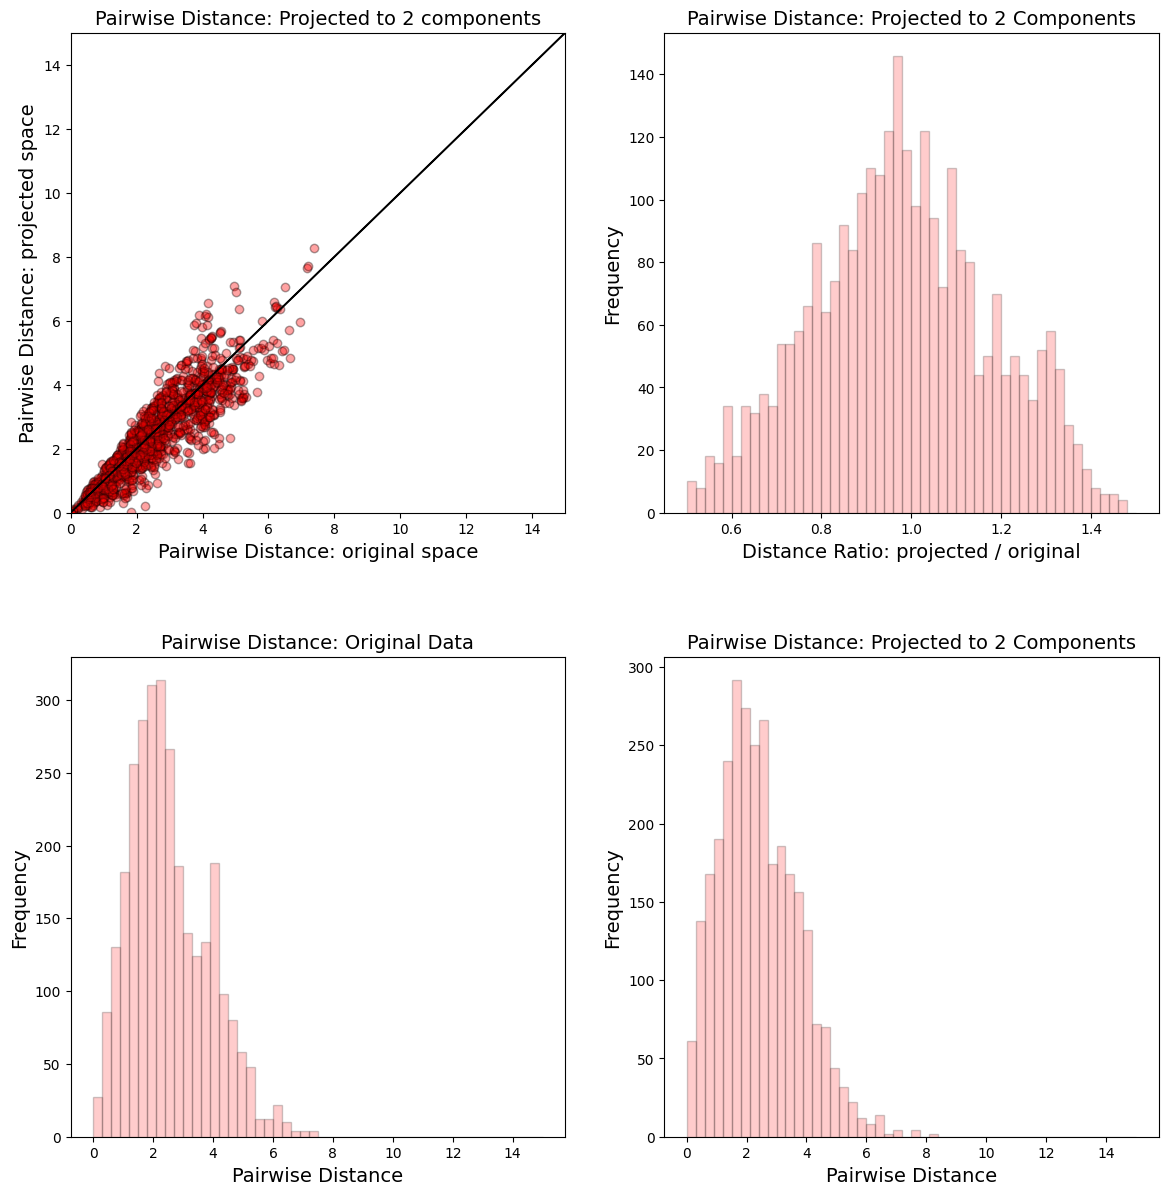

Distance Ratio, mean: 0.9535, standard deviation: 0.2407.


In [27]:
obj.visual_model_check(norm_type='L1', fig_name='Model check for N case samples distortion', array=E, expectation_compute=True, save=True)

From the above, We projected to a 2 dimensional feature space and did a pretty good job preserving the pairwise distances between the samples.


Now, let's find the convex hull polygon and identify the anchor points for the n-case scenario in the lower dimensional space.

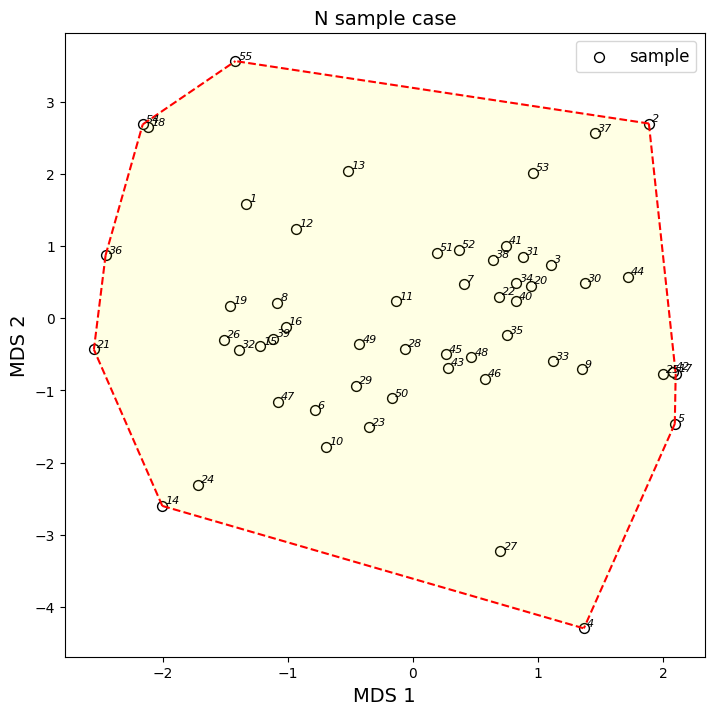

In [28]:
my_points, hull, vertices = obj.convex_hull(array=all_real, num_OOSP=None, title='N sample case', x_off=0.025, y_off=0.03, Ax=Ax, Ay=Ay, make_figure=make_figure, expectation_compute=False, save=True)

Visualize the marginal distributions for each predictor and threshold at which proposed methodology will work and/or fail. This is shown because if the OOSP is chosen from the tails, the vertices of the anchor set might change, making stabilization a non-trivial task.

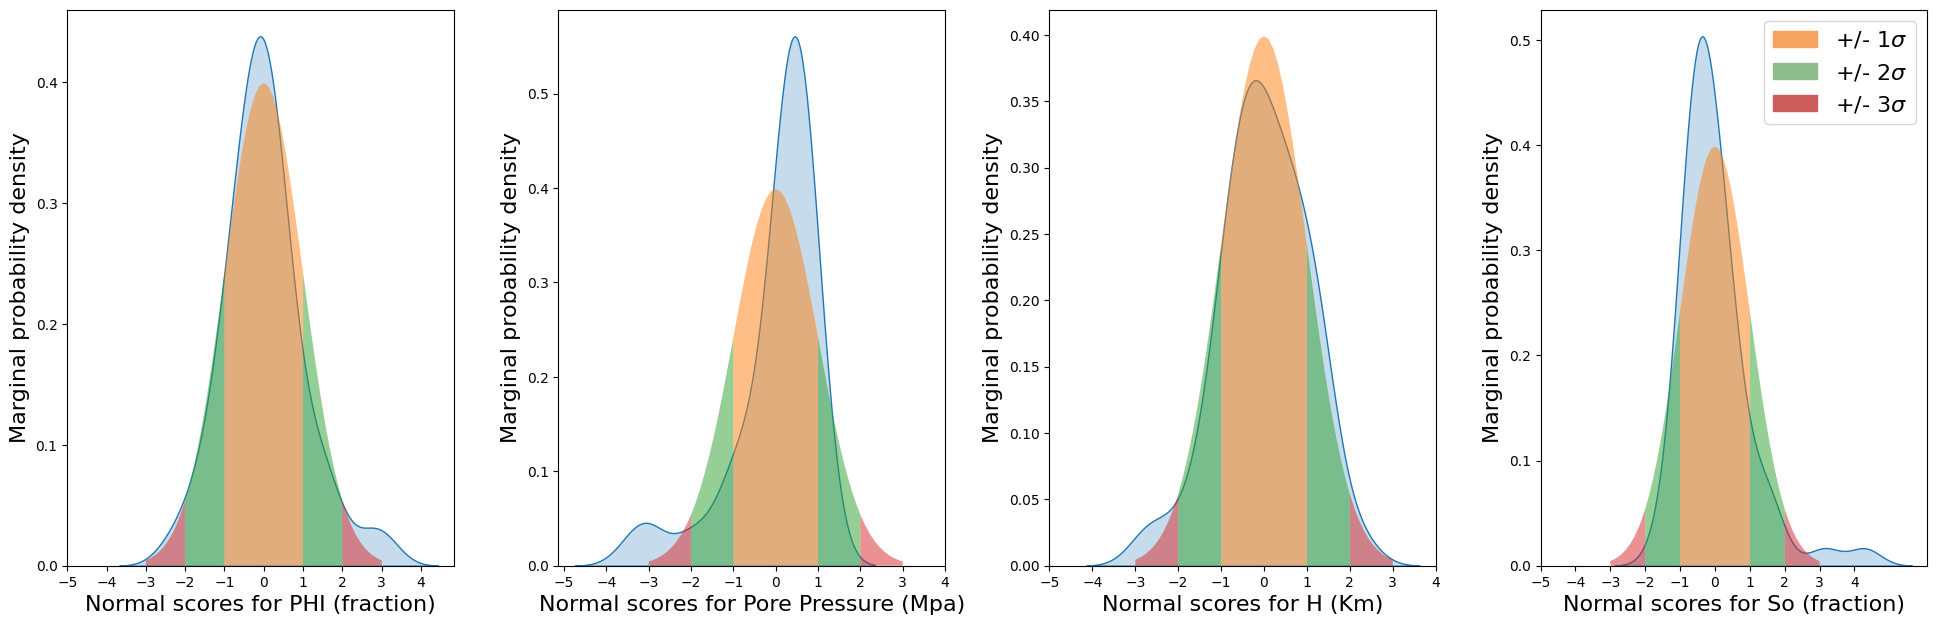

In [29]:
obj.marginal_dbn(save=True)


<br>

<br>



# Section 2:  For N + 1 Case with OOSP
<br>

Add OOSP to data and run.

In [30]:
# Instantiate the class
obj2 = RT.RigidTransf_NPlus(df=df_subset2, features=features, num_OOSP=num_OOSP, idx=idx, num_realizations=num_realizations, base_seed=base_seed, start_seed=start_seed, stop_seed=stop_seed, dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection, custom_dij=None)

In [31]:
# Run rigid MDS
random_seeds2, all_real2, calc_real2, all_rmse2, norm_stress2 = obj2.run_rigid_MDS(normalize_projections = normalize_projections)

Visualize base case and three example realizations

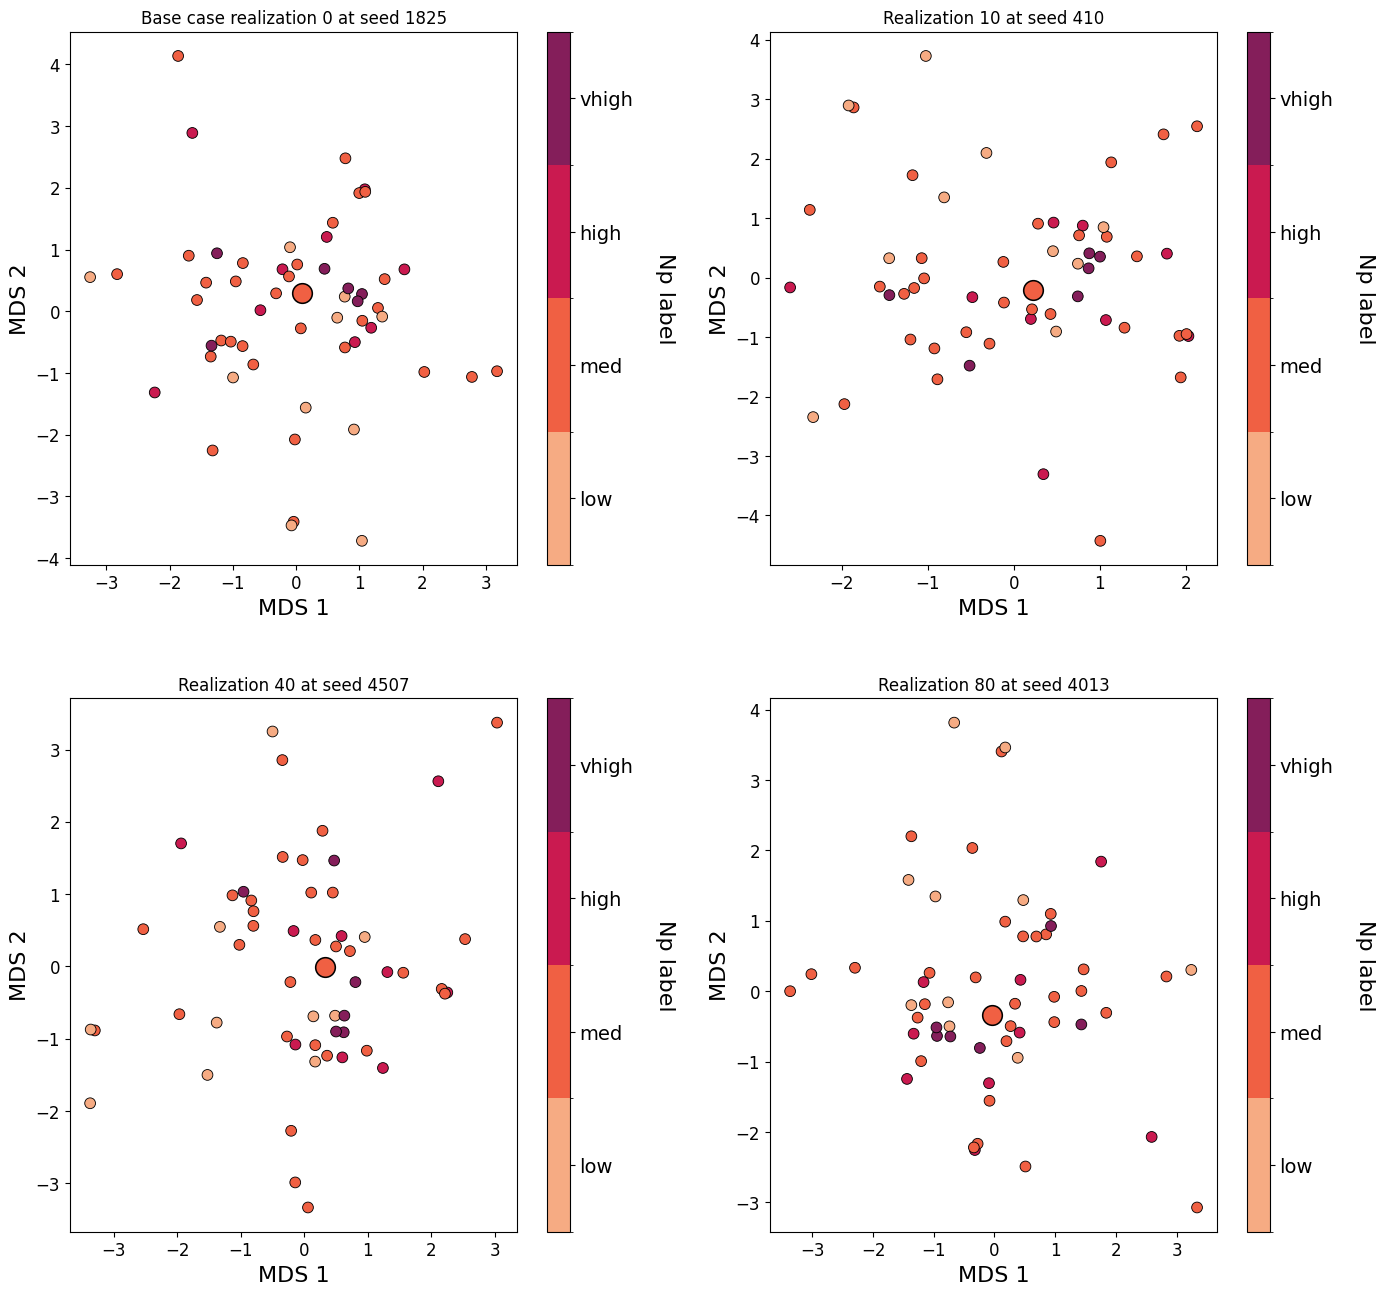

In [32]:
obj2.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off,cmap=dpalette, n_case=False, annotate=False, array2=None, save=True)

Visualize the base case and stabilized solution for prior example realizations

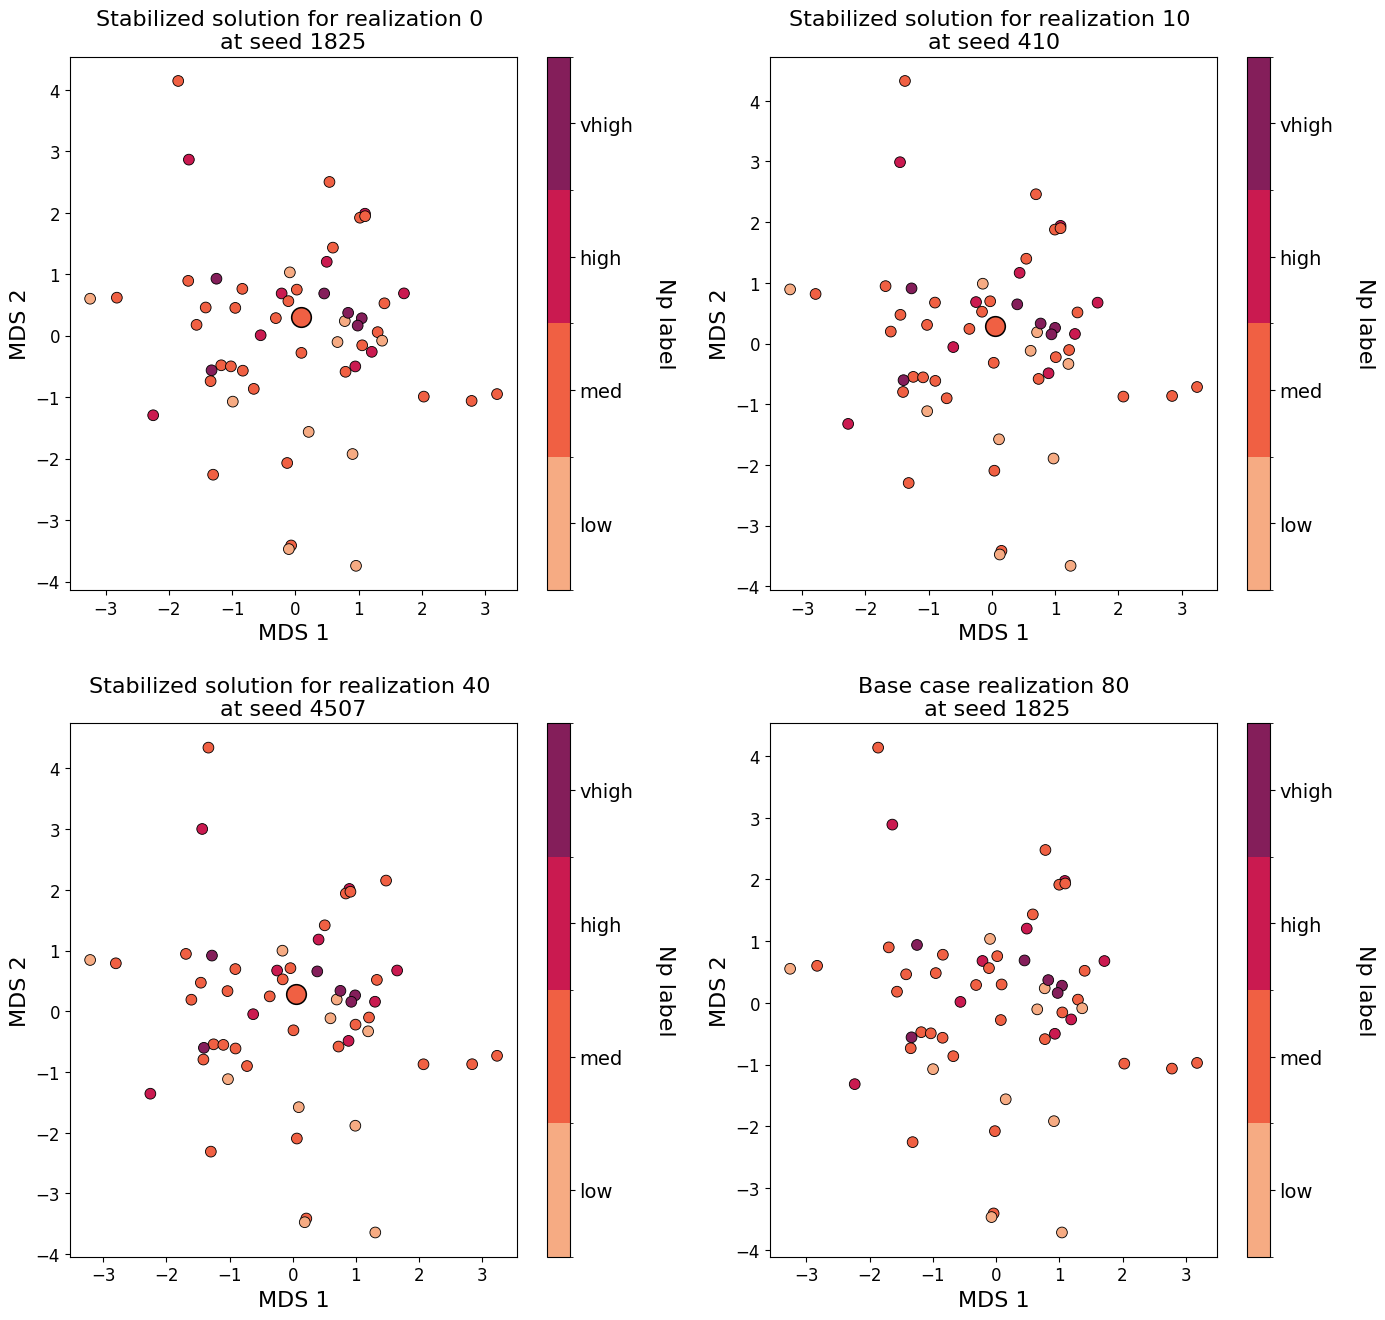

In [33]:
obj2.real_plotter(response=response, r_idx=r_list, Ax=Ax, Ay=Ay , title=title, x_off=x_off, y_off=y_off,cmap=dpalette, annotate=False,n_case=False, array2=calc_real2, save=True)

Since using the ensemble expectation of the stabilized solution helps remove effects from slight random offsets, perturbations, or distortions if any within the n+1-sample demonstration.

In [34]:
# Set base case index of choice for N+1 scenario
bc_idx =0 # new_idx


E2 = obj2.expectation(r_idx=bc_idx, Ax=Ax, Ay=Ay, verbose=True)

The effective variance of the base case is 3.7817 with a MDS 1 variance of 1.7074 and MDS 2 variance of 2.0744
The effective variance of the expected stabilized solution is 3.7204 with a MDS 1 variance of 1.682 and MDS 2 variance of 2.0383


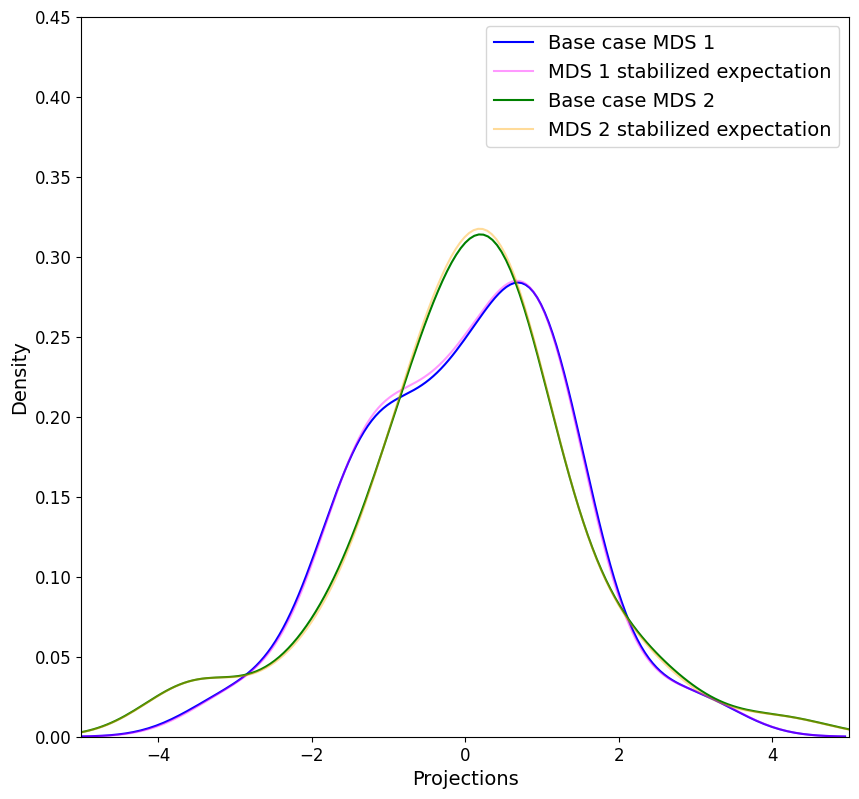

In [35]:
xmin2 = -5
xmax2 = 5
ymin2 = 0.0
ymax2 = 0.45

obj2.expect_plotter(r_idx=bc_idx, Lx=Ax, Ly=Ay, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, save=True)

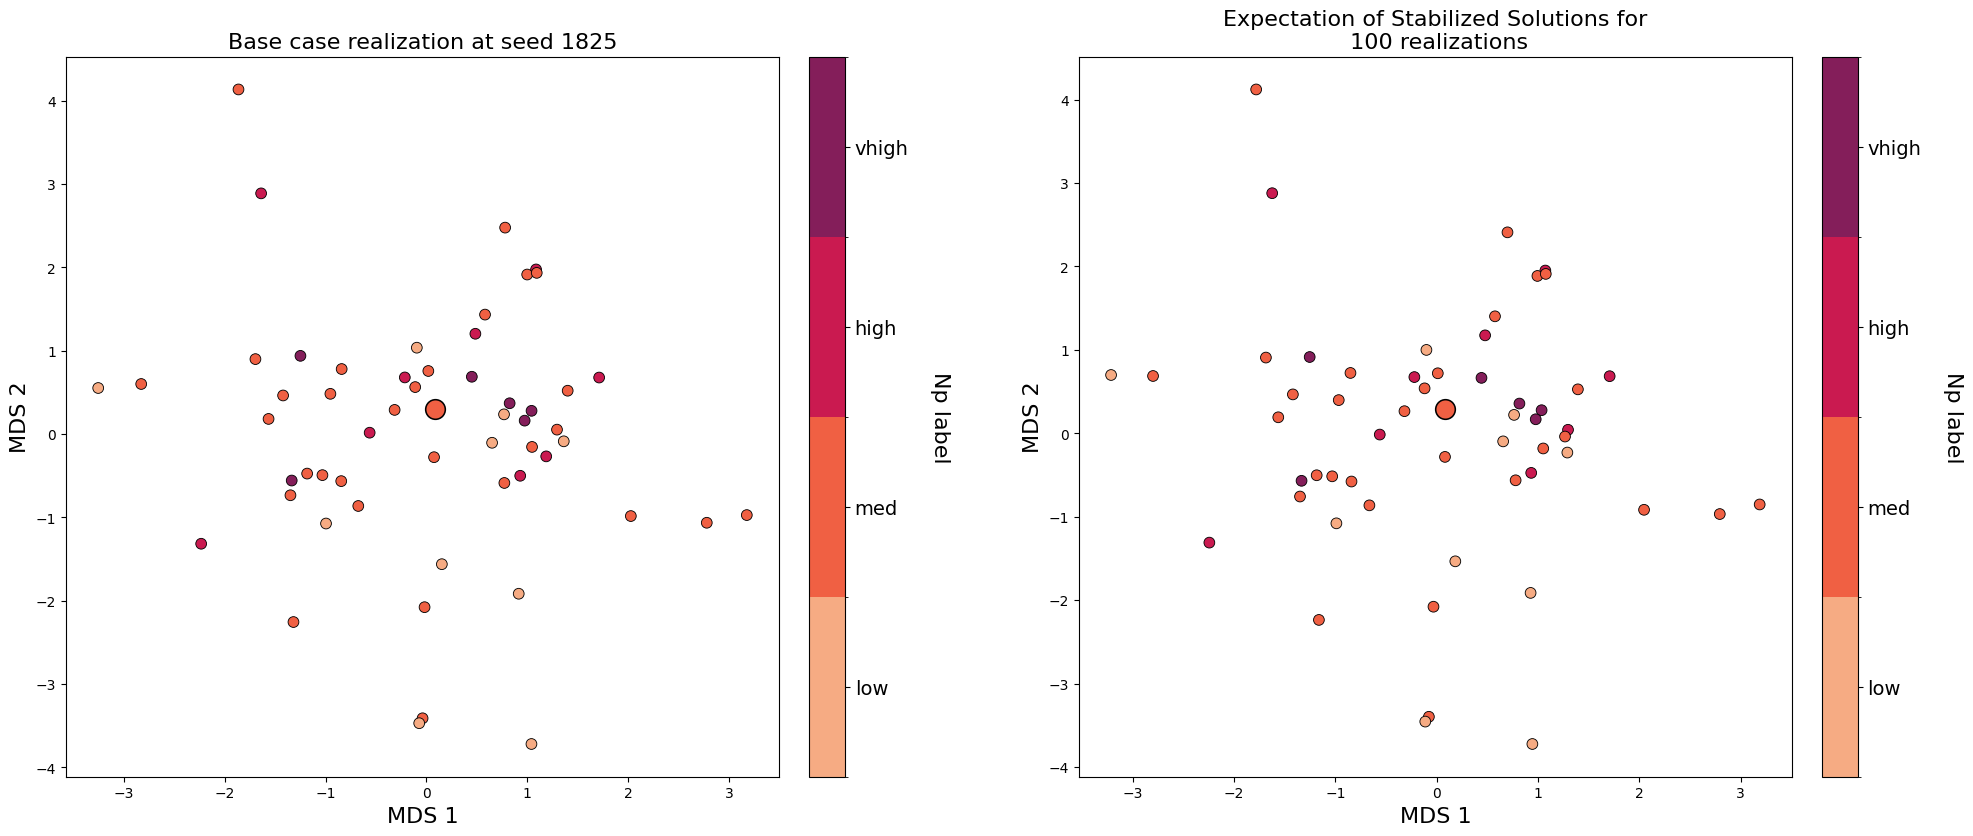

In [36]:
obj2.compare_plot(response=response, r_idx=bc_idx, Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off, n_case=False, annotate=False, cmap=dpalette, save=True)

Find the convex hull polygon of the expected stabilized solution for all realizations in the n+1 scenario

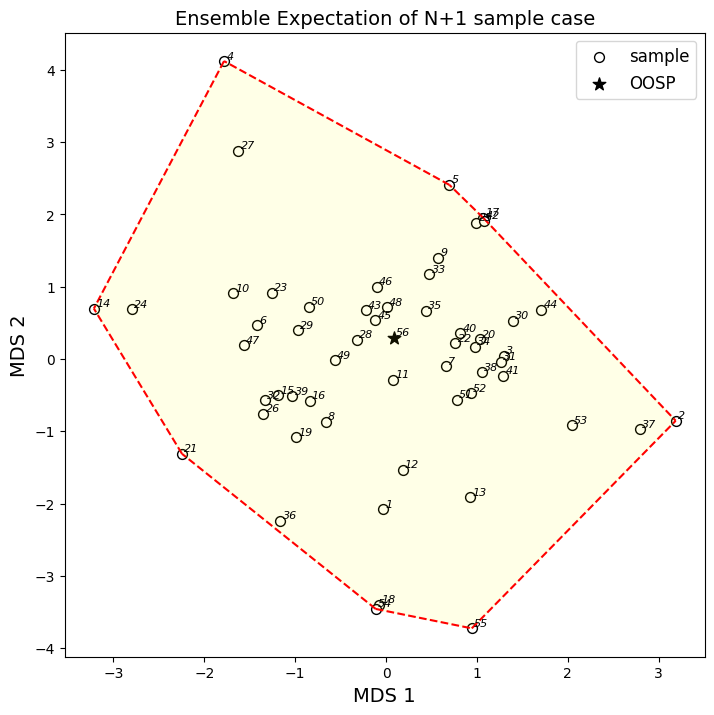

In [37]:
my_points_expected, hull_expected, vertices_expected = obj2.convex_hull(array=E2, num_OOSP=num_OOSP, title='Ensemble Expectation of N+1 sample case', x_off=0.025, y_off=0.03, Ax=Ax, Ay=Ay, make_figure=make_figure, expectation_compute=True, n_case=False, save=True) #0.01,0.015

Stabilize the anchors from the N+1 case to match the N-case such that the same representation is obtained and visualize.

Find stabilized expected anchor representation and visualize

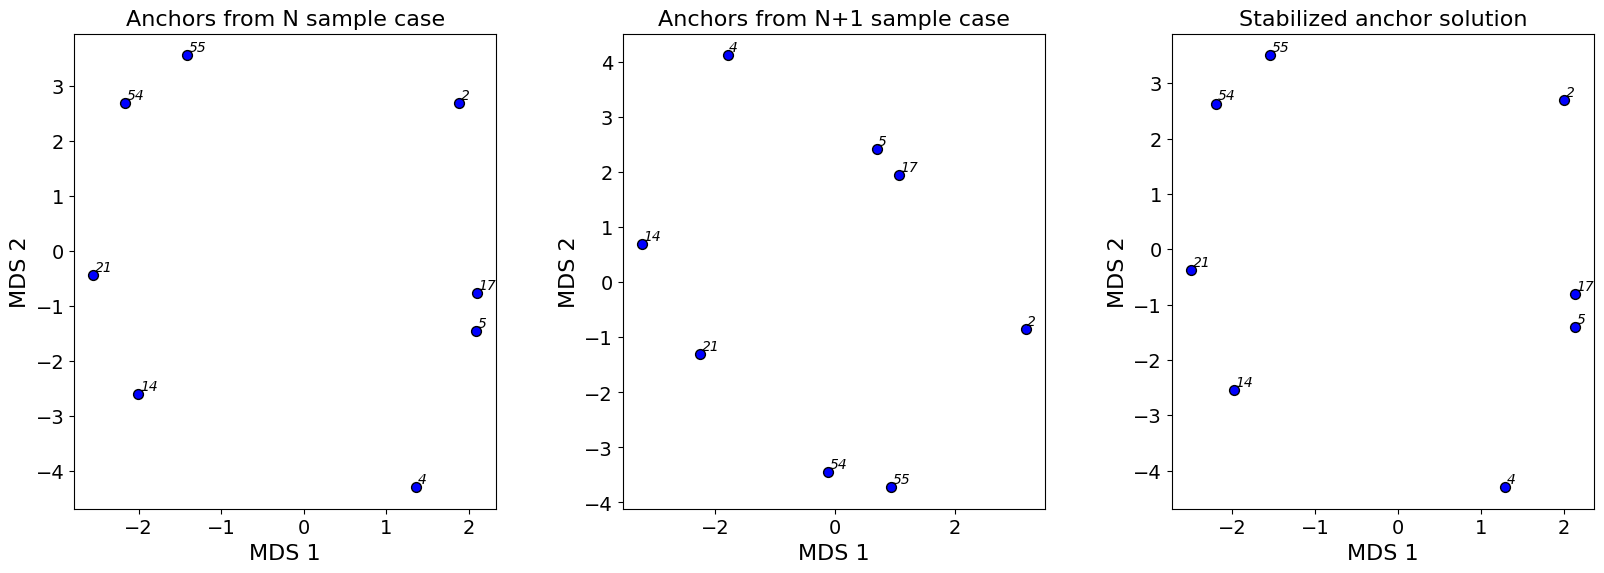

In [38]:
anchors1_exp, anchors2_exp, R_anchors_exp, t_anchors_exp, rmse_err_anchors_exp, stable_coords_anchors_exp, stable_coords_alldata_exp, rmse_err_alldata_exp = obj2.stabilize_anchors(array1=my_points, array2=my_points_expected, hull_1=hull, hull_2=hull_expected, normalize_projections=normalize_projections)

obj2.stable_anchor_visuals( Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off)

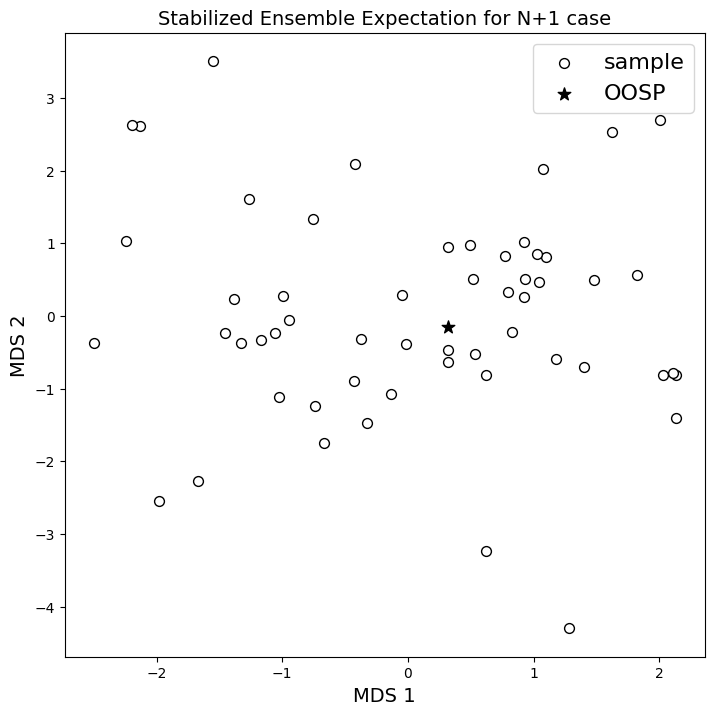

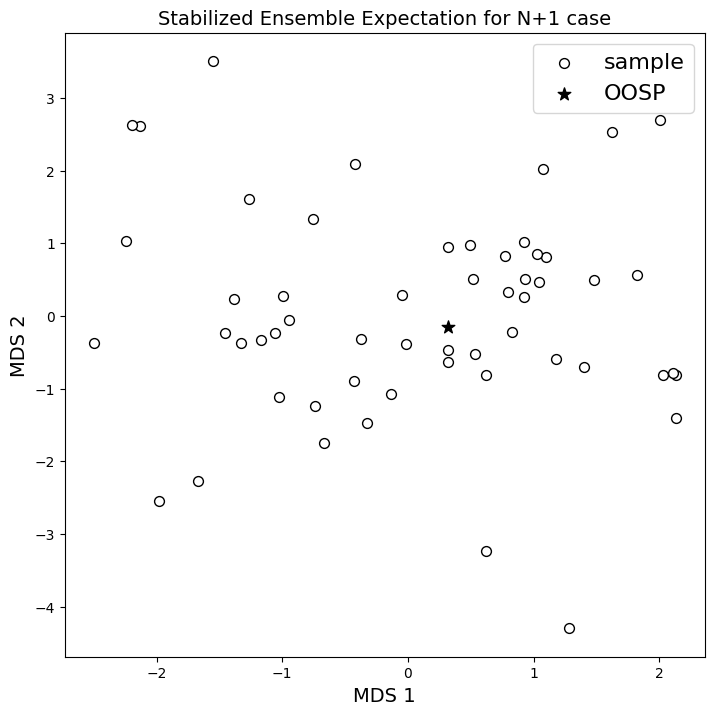

In [39]:
obj2.stable_representation(title='Stabilized Ensemble Expectation for N+1 case', Ax=Ax, Ay=Ay, annotate=False, x_off=x_off, y_off=y_off)

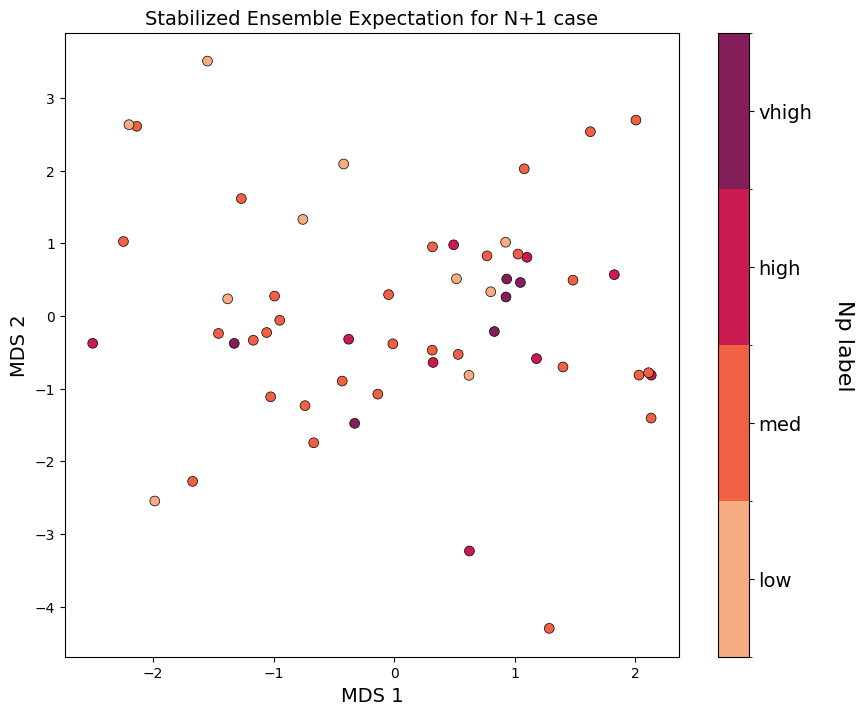

In [40]:
obj2.stabilized_all_plotter(dataframe=df_subset, hue_='Np label', palette_=1, annotate=False, n_case=True, save=True) # colored by just production level for N case

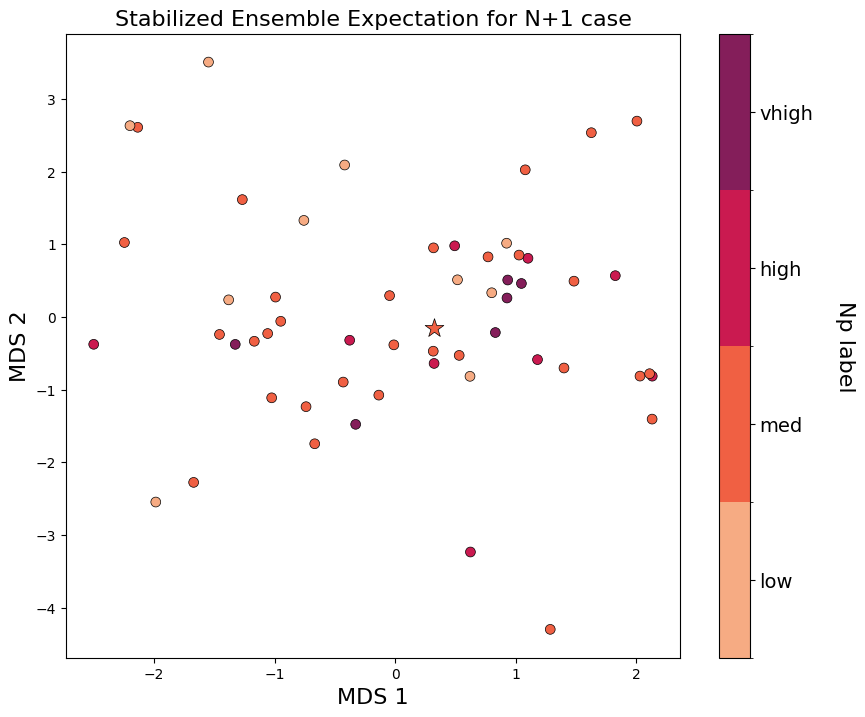

In [41]:
obj2.stabilized_all_plotter(dataframe=df_subset2, hue_='Np label', palette_=1, annotate=False, n_case=False, save=True) # With OOSP colored by production level

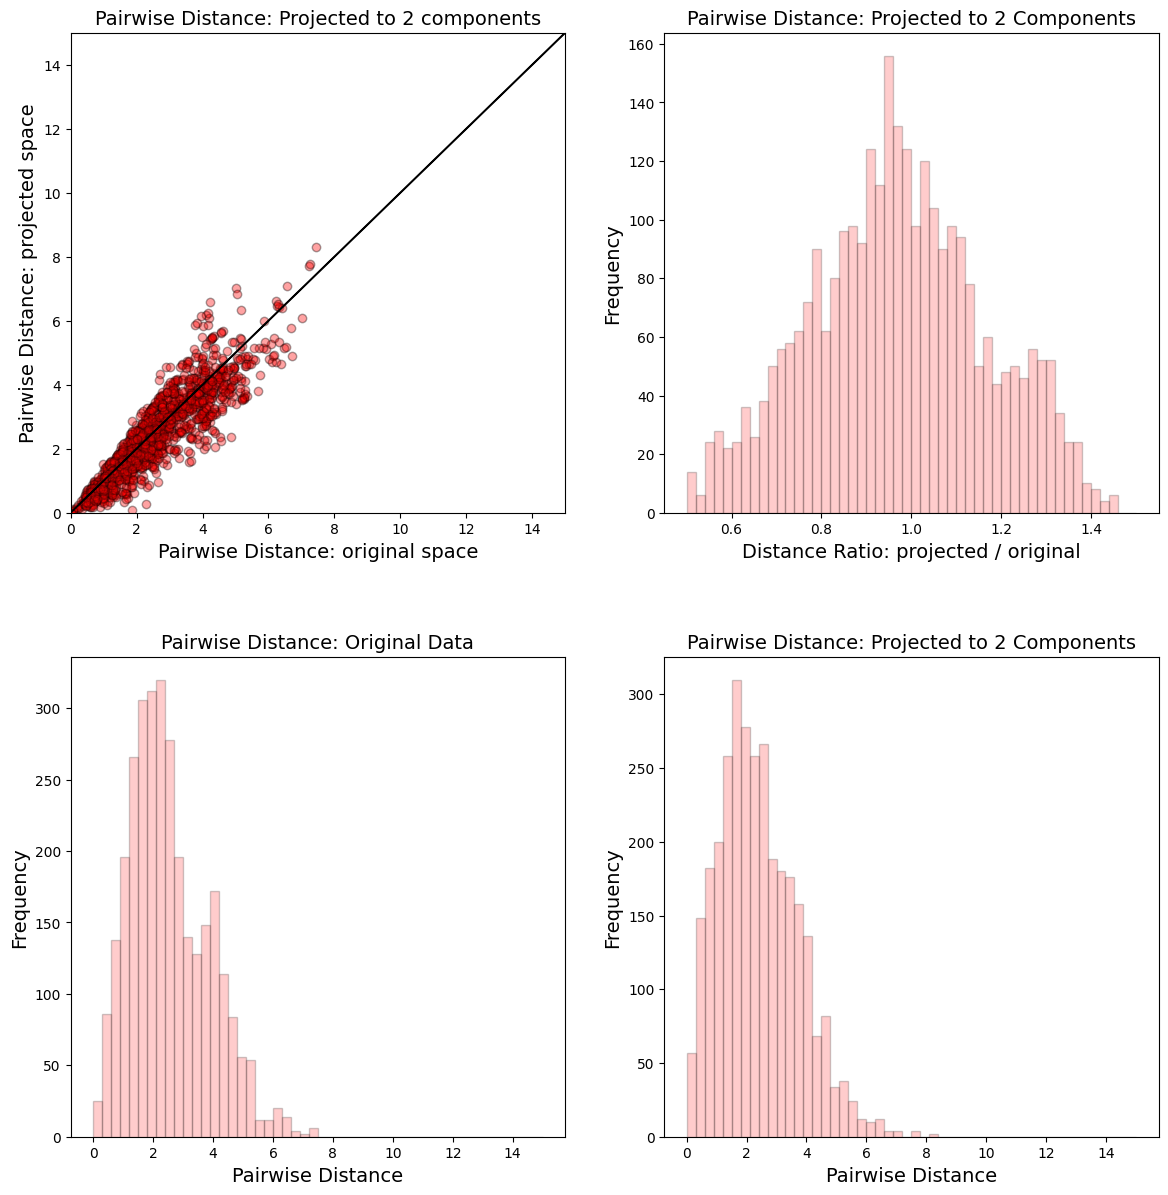

Distance Ratio, mean: 0.9483, standard deviation: 0.2357.


In [42]:
obj2.visual_model_check(norm_type='L1', fig_name='Model check for the expectation of N+1 case samples distortion', array=E2, expectation_compute=True, save=True)

In [43]:
print("The average, minimum, and maximum stress values for the realizations in the n-scenario are ", round(np.mean(norm_stress),5) , round(np.min(norm_stress),5)
      , round(np.max(norm_stress),5))

print("The average, minimum, and maximum stress values for the realizations in the n+1 -scenario are ", round(np.mean(norm_stress2),5) , round(np.min(norm_stress2),5)
      , round(np.max(norm_stress2),5))

The average, minimum, and maximum stress values for the realizations in the n-scenario are  0.19434 0.19401 0.1955
The average, minimum, and maximum stress values for the realizations in the n+1 -scenario are  0.1936 0.19315 0.20585


In [44]:
# my_points2, hull2, vertices2 = obj2.convex_hull(array=all_real2, num_OOSP=num_OOSP, title='N+1 sample case', x_off=0.025, y_off=0.03, Ax=Ax, Ay=Ay, make_figure=make_figure, expectation_compute=False, n_case=False,save=True)

# #  Visualize the 2D registration jitters in n+1 case
# obj2.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='2-D registration distortion in N+1 case stabilized solutions',
#                          plot_type='jitters', Ax=Ax, Ay=Ay, annotate=False)
#
# obj2.bivariate_plotter(palette_=1, response=response, x_off=x_off, y_off=y_off, title='2-D registration distortion in N+1-case stabilized solutions',
#                          plot_type='uncertainty', Ax=Ax, Ay=Ay, annotate=False, save=True)

# anchors1, anchors2, R_anchors, t_anchors, rmse_err_anchors, stable_coords_anchors, stable_coords_alldata, rmse_err_alldata = obj2.stabilize_anchors(array1=my_points, array2=my_points2, hull_1=hull, hull_2=hull2, normalize_projections=False)
#
# obj2.stable_anchor_visuals(Ax=Ax, Ay=Ay, x_off=x_off, y_off=y_off)

# # Visualize the stable representation for all samples in the dataset
# obj2.stable_representation(title='Stabilized N+1 case', Ax=Ax, Ay=Ay, annotate=False, x_off=x_off, y_off=y_off)

# obj2.visual_model_check(norm_type='L1', fig_name='Model check for N+1 case samples distortion', array=stable_coords_alldata, expectation_compute=False)

# Section 3: Predictor magnitude variations

To highlight the capabilities of the workflow. Let's vary the magnitude of porosity as a predictor feature for the OOSP and see how it moves in the LDS

In [45]:
def single_predictor():
    multiplier = [0.8, 0.9, 1.0, 1.1, 1.2]
    for i,factor in enumerate(multiplier):
        data_ = df_subset2.copy()
        data_.loc[len(df_subset), 'PHI (fraction)'] = factor * data_.loc[len(df_subset), 'PHI (fraction)']

        # Instantiate the class
        obj_ = RT.RigidTransf_NPlus(df=data_, features=features, num_OOSP=num_OOSP, idx=idx,
                                   num_realizations=2, base_seed=base_seed,
                                   start_seed=start_seed, stop_seed=stop_seed,
                                   dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection,
                                   custom_dij=None)
        # Run rigid MDS
        random_seeds_, all_real_, calc_real_, all_rmse_, norm_stress_ = obj_.run_rigid_MDS(normalize_projections=normalize_projections)

        # Convex hull polygon
        my_points_, hull_, vertices_ = obj_.convex_hull(array=all_real_, num_OOSP=num_OOSP,
                                                       title='N+1 sample case', x_off=0.025, y_off=0.03,
                                                       Ax=Ax, Ay=Ay, make_figure=False,
                                                       expectation_compute=False, n_case=False, save=True)

        _, _, _, _, _, _, _, _= obj_.stabilize_anchors(array1=my_points, array2=my_points_, hull_1=hull, hull_2=hull_, normalize_projections=False)

        # Plot the stable representation in the current subplot
        obj_.stable_representation(title=f'Stabilized N+1 case (multiplier={factor})', Ax=Ax, Ay=Ay, annotate=False,
                                   x_off=x_off, y_off=y_off, make_figure=False)

        obj_.stabilized_all_plotter(dataframe=data_, hue_='Np label', palette_=1, annotate=False, n_case=False, save=True)

    # Show the plot
    plt.show()


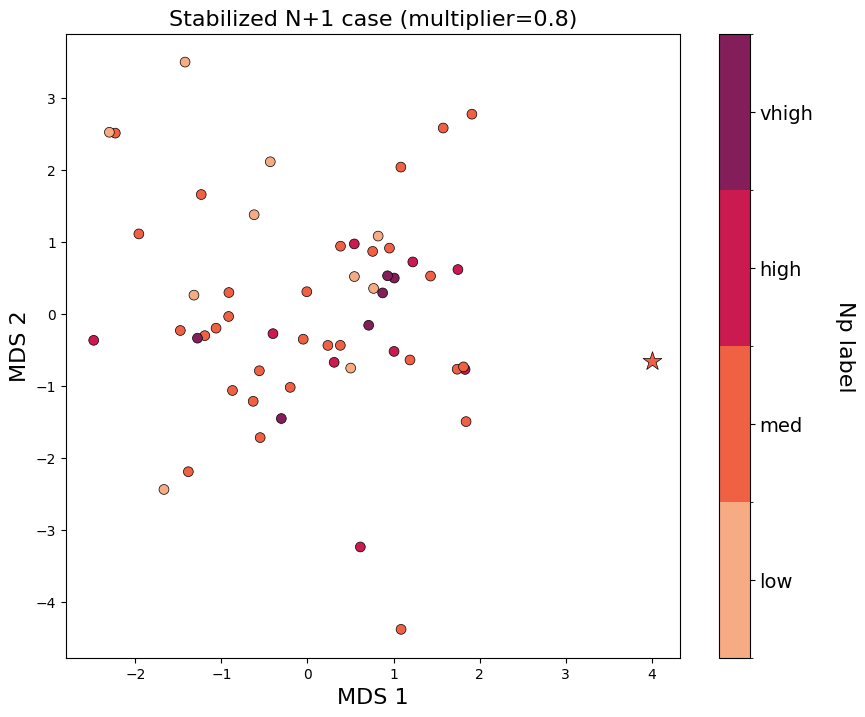

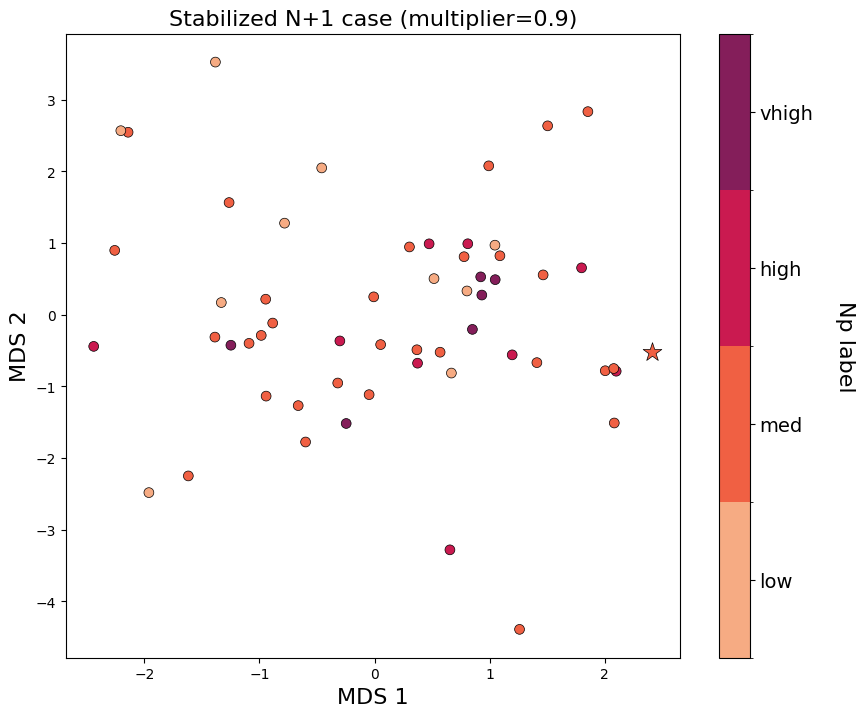

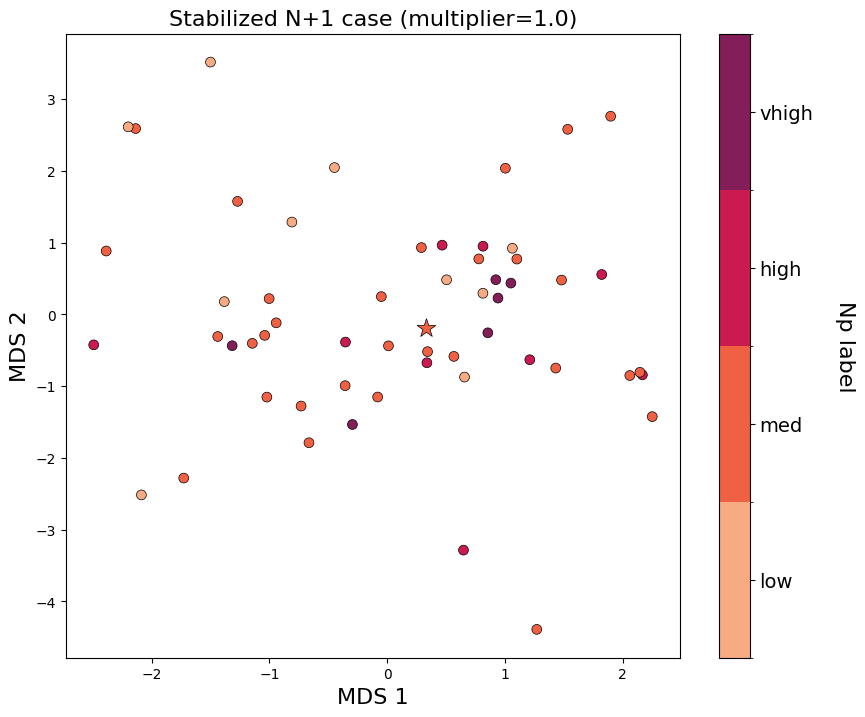

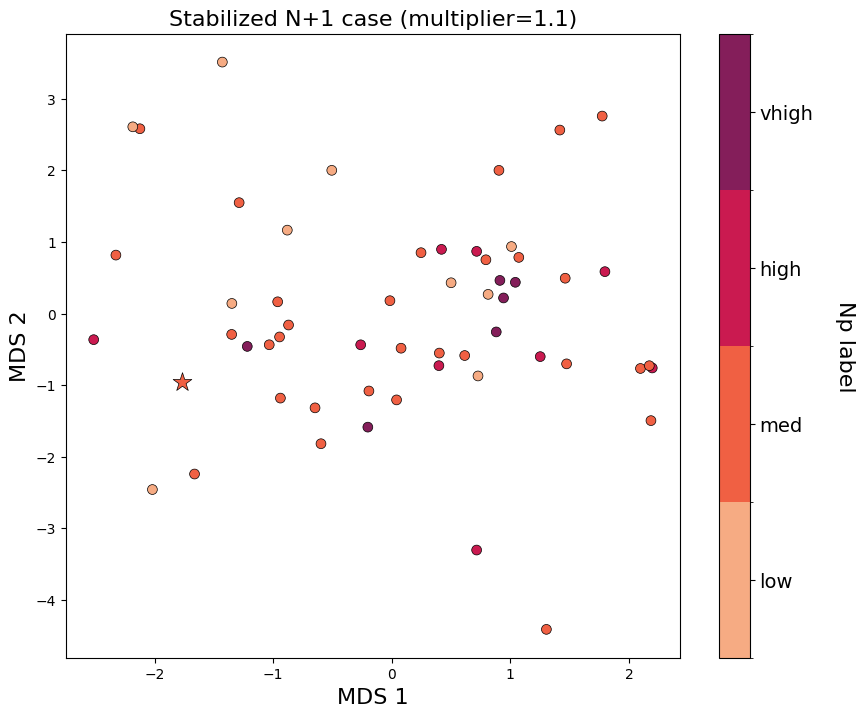

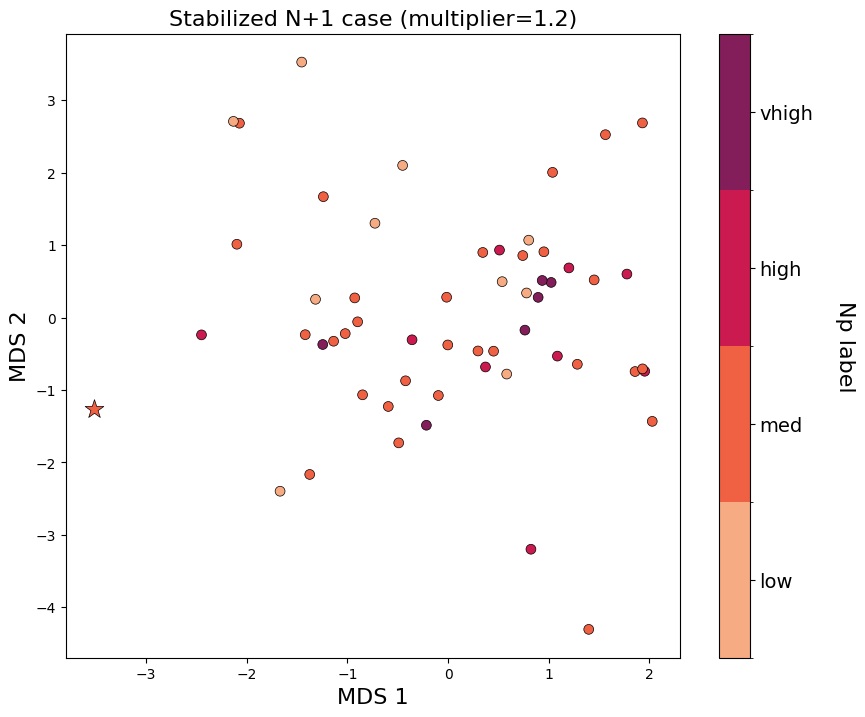

In [46]:
# Run function above
single_predictor()

Change the magnitude of two predictor features i.e. porosity and pore pressure at the same time for the OOSP and see how it changes the LDS

In [47]:
def multi_predictor():
    multiplier = [0.8, 0.9, 1.0, 1.1, 1.2]
    for i,factor in enumerate(multiplier):
        data_ = df_subset2.copy()
        data_.loc[len(df_subset), 'PHI (fraction)'] = factor * data_.loc[len(df_subset), 'PHI (fraction)']
        # data_.loc[len(df_subset), 'H (Km)'] = factor * data_.loc[len(df_subset), 'H (Km)']
        data_.loc[len(df_subset), 'Pore Pressure (Mpa)'] = factor * data_.loc[len(df_subset), 'Pore Pressure (Mpa)']

        # Instantiate the class
        obj_ = RT.RigidTransf_NPlus(df=data_, features=features, num_OOSP=num_OOSP, idx=idx,
                                   num_realizations=4, base_seed=base_seed,
                                   start_seed=start_seed, stop_seed=stop_seed,
                                   dissimilarity_metric=dissimilarity_metric, dim_projection=dim_projection,
                                   custom_dij=None)
        # Run rigid MDS
        random_seeds_, all_real_, calc_real_, all_rmse_, norm_stress_ = obj_.run_rigid_MDS(normalize_projections=normalize_projections)

        # Convex hull polygon
        my_points_, hull_, vertices_ = obj_.convex_hull(array=all_real_, num_OOSP=num_OOSP,
                                                       title='N+1 sample case', x_off=0.025, y_off=0.03,
                                                       Ax=Ax, Ay=Ay, make_figure=False,
                                                       expectation_compute=False, n_case=False, save=True)

        _, _, _, _, _, _, _, _= obj_.stabilize_anchors(array1=my_points, array2=my_points_, hull_1=hull, hull_2=hull_, normalize_projections=False)

        # Plot the stable representation in the current subplot
        fig = obj_.stable_representation(title=f'Stabilized N+1 case (multiplier={factor})', Ax=Ax, Ay=Ay, annotate=False,
                                   x_off=x_off, y_off=y_off, make_figure=False)

        obj_.stabilized_all_plotter(dataframe=data_, hue_='Np label', palette_=1, annotate=False, n_case=False, save=True)

    # Show the plot
    plt.show()


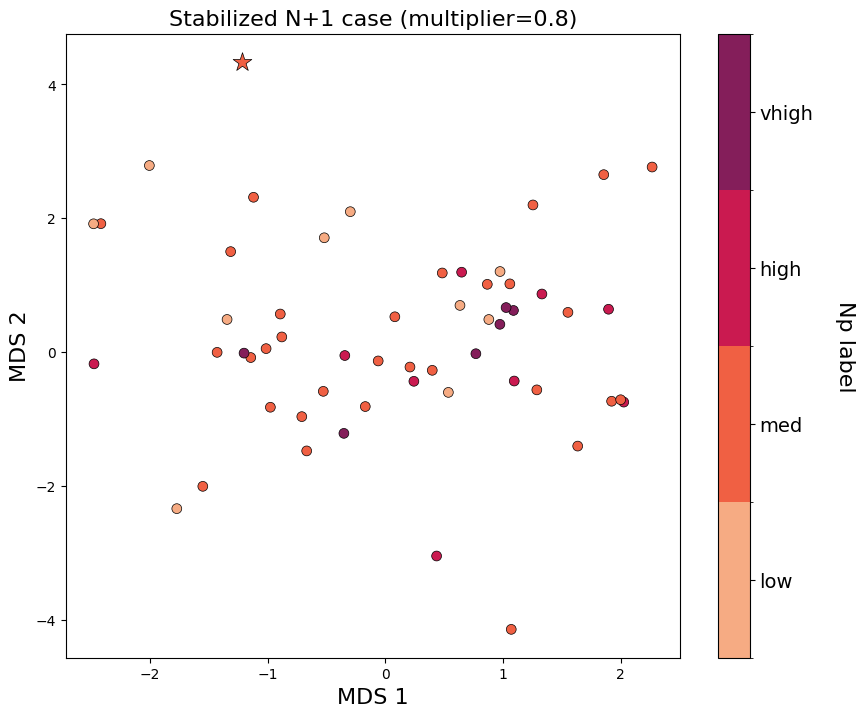

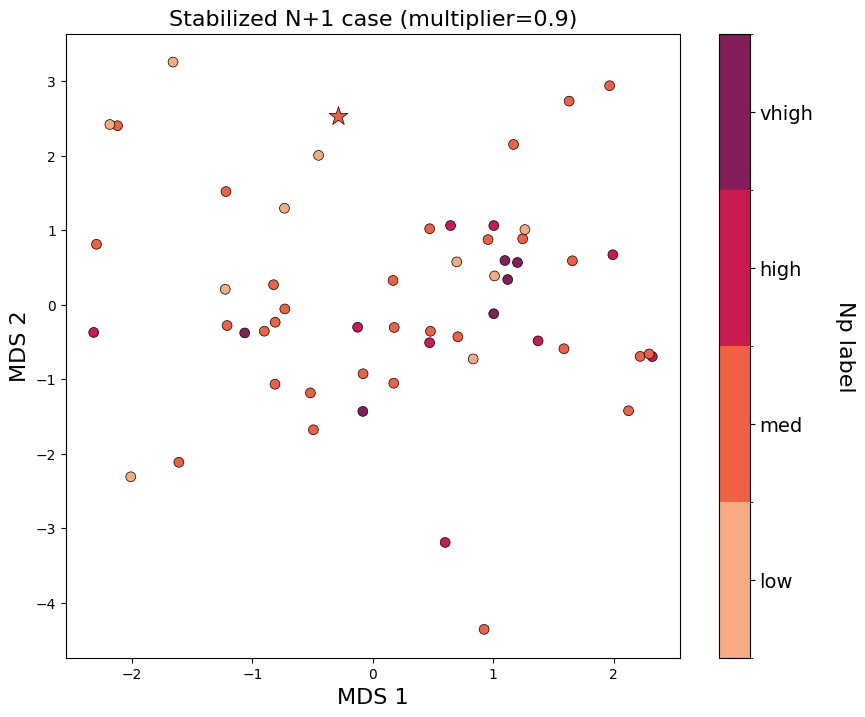

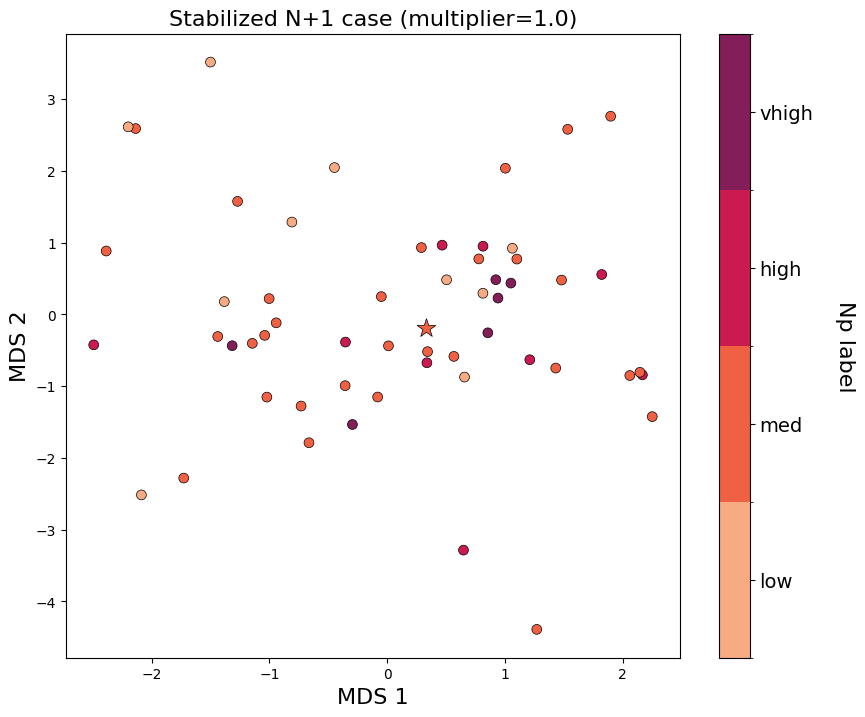

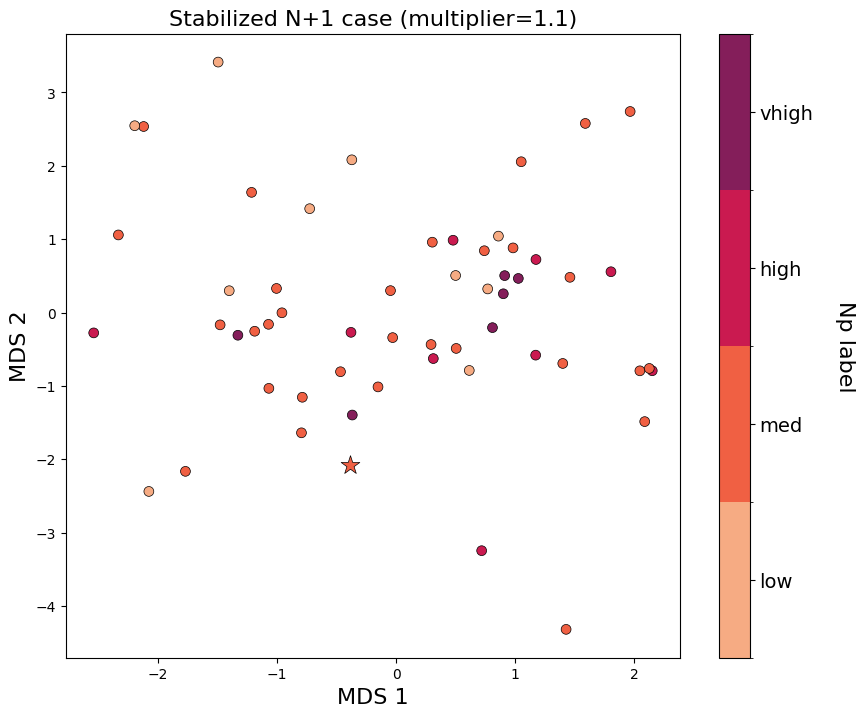

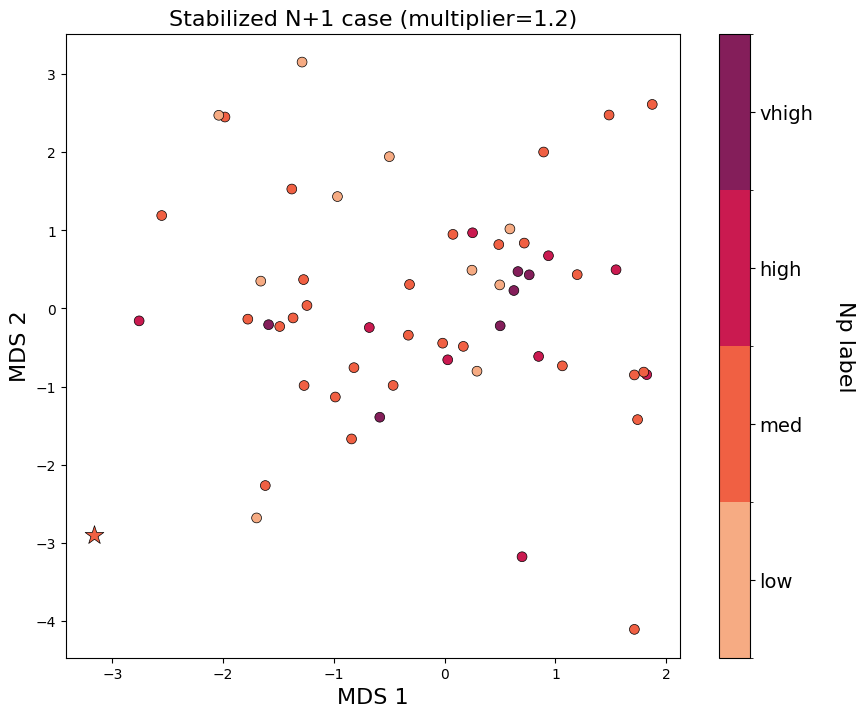

In [48]:
multi_predictor()

1. Plot background of krigged production and turn points to white color, perhaps use with stable_representation function
2. Plot N dataset and OOSP in original feature space too.

In [49]:
# # Plot the stable representation in the current subplot
# fig = obj_.stable_representation(title=f'Stabilized N+1 case (multiplier={factor})', Ax=Ax, Ay=Ay, annotate=False,
#                            x_off=x_off, y_off=y_off, make_figure=False)
#
# ax = fig.axes[0]
#
# # Load kriged cum. oil production data in MDS space
# img = np.load('Kriged Cum. Gas in MDS Space.npy')
#
# # Plot the image as the background using imshow
# ax.imshow(img, cmap='gray', extent=[xmin, xmax, ymin, ymax])
#
# # Add additional plot elements or annotations
# ax.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25], 'r-', label='Line')
#
# # Show the figure
# plt.show()

In [53]:
# Plot the stable representation in the current subplot
fig = obj2.stable_representation(title='Stabilized N+1 case (multiplier={})', Ax=Ax, Ay=Ay, annotate=False,
                           x_off=x_off, y_off=y_off, make_figure=False)

ax = fig.axes[0]

# Load kriged cum. oil production data in MDS space
img = np.load('Kriged Cum. Gas in MDS Space.npy')

# Plot the image as the background using imshow
ax.imshow(img, cmap='gray', extent=[xmin, xmax, ymin, ymax])

# Show the figure
plt.show()

AttributeError: 'NoneType' object has no attribute 'axes'